In [206]:
import os
import pickle

import scipy.stats as st
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from sklearn import ensemble, svm
from sklearn.metrics import balanced_accuracy_score, classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import RobustScaler, StandardScaler

import npc_lims
from npc_sessions import DynamicRoutingSession
from dynamic_routing_analysis import spike_utils, decoding_utils


In [ ]:
#general decoder function

#take several inputs:
#which decoding algorithm - linearSVC, other SVC, Random forest, etc.
#crossval strategy (separate function for generating this) - random, same proportion per block, blockwise, exclude first block, etc.

#old function:

def flexible_decoder(input_data,labels,params):
    
    #scaler, crossval, crossval_index, crossval_strategy, crossval_params, classifier, classifier_params, output_params


    output={}

    scaler = StandardScaler()
    # scaler = RobustScaler()

    scaler.fit(input_data)
    X = scaler.transform(input_data)
    # X = input_data
    unique_labels=np.unique(labels)
    if labels_as_index==True:
        labels=np.array([np.where(unique_labels==x)[0][0] for x in labels])

    y = labels

    if len(np.unique(labels))>2:
        y_dec_func=np.full((len(y),len(np.unique(labels))), fill_value=np.nan)
    else:
        y_dec_func=np.full(len(y), fill_value=np.nan)
 
    if type(y[0])==bool:
        ypred=np.full(len(y), fill_value=False)
    elif type(y[0])==str:
        ypred=np.full(len(y), fill_value='       ')
    else:
        ypred=np.full(len(y), fill_value=np.nan)

    tidx_used=[]
    
    coefs=[]
    classes=[]
    intercept=[]
    params=[]
    ypred_train=[]
    ytrue_train=[]
    train_trials=[]
    test_trials=[]
    models=[]

    #make train, test splits based on block number
    if crossval=='blockwise':
        if crossval_index is None:
            raise ValueError('Must provide crossval_index')
        train=[]
        test=[]
        block_number=crossval_index
        block_numbers=np.unique(block_number)
        for bb in block_numbers:
            not_block_inds=np.where(block_number!=bb)[0]
            train.append(not_block_inds)

            # #equalize number of trials for each condition
            # subset_ind=[]
            # conds = np.unique(y[not_block_inds])
            # cond_count=[]
            # for cc in conds:
            #     cond_count.append(np.sum(y[not_block_inds]==cc))
            # use_trnum=np.min(cond_count)
            # for cc in conds:
            #     cond_inds=np.where(y[not_block_inds])[0]
            #     subset_ind.append(np.random.choice(cond_inds,use_trnum,replace=False))   
            # subset_ind=np.sort(np.hstack(subset_ind))
            # train.append(not_block_inds[subset_ind])

            block_inds=np.where(block_number==bb)[0]
            test.append(block_inds)
        train_test_split=zip(train,test)
    elif crossval=='5_fold':
        skf = StratifiedKFold(n_splits=5,shuffle=True)
        train_test_split = skf.split(input_data, labels)


    for train,test in train_test_split:
        # clf=svm.LinearSVC(max_iter=5000,dual='auto',class_weight='balanced')
        clf=svm.SVC(class_weight='balanced',kernel='linear',probability=True)
        
        clf.fit(X[train],y[train])
        ypred[test] = clf.predict(X[test])
        ypred_train.append(clf.predict(X[train]))
        ytrue_train.append(y[train])
        y_dec_func[test] = clf.decision_function(X[test])
        tidx_used.append([test])
        # coefs.append(clf.dual_coef_)
        coefs.append(clf.coef_) #for linear SVC only
        classes.append(clf.classes_)
        intercept.append(clf.intercept_)
        params.append(clf.get_params())
        train_trials.append(train)
        test_trials.append(test)

        models.append(clf)

    cr_dict=classification_report(y, ypred, output_dict=True)
    balanced_accuracy=balanced_accuracy_score(y, ypred, sample_weight=None, adjusted=False)

    cr_dict_train=classification_report(np.hstack(ytrue_train), np.hstack(ypred_train), output_dict=True)
    balanced_accuracy_train=balanced_accuracy_score(np.hstack(ytrue_train), np.hstack(ypred_train), sample_weight=None, adjusted=False)

    output['cr']=cr_dict
    output['pred_label']=ypred
    output['true_label']=y
    output['trials_used']=tidx_used
    output['decision_function']=y_dec_func
    output['coefs']=coefs
    output['classes']=classes
    output['intercept']=intercept
    output['params']=params
    output['balanced_accuracy']=balanced_accuracy
    
    output['pred_label_train']=np.hstack(ypred_train)
    output['true_label_train']=np.hstack(ytrue_train)
    output['cr_train']=cr_dict_train
    output['balanced_accuracy_train']=balanced_accuracy_train
    output['train_trials']=train_trials
    output['test_trials']=test_trials
    output['models']=models
    output['scaler']=scaler
    output['label_names']=unique_labels
    output['input_data']=input_data
    output['labels']=labels

    return output


In [ ]:
#decoder wrapper function

#loops through different iterations, params, etc. and calls flexible_decoder

#saves the input data and labels, indices for each run, and the output of flexible_decoder

In [129]:
#select input data for easy iteration

# sel_sessions=['668755_2023-08-30','681532_2023-10-17']

# sel_sessions=['2023-07-11_10-07-43_668759']
# project='TempletonPilot'
sel_sessions=['662892_2023-08-24']

session=DynamicRoutingSession(sel_sessions[0])

# session.units[:]
# session.trials[:]

trials=pd.read_parquet(
            npc_lims.get_cache_path('trials',session.id,version='v0.0.173')
        )
units=pd.read_parquet(
            npc_lims.get_cache_path('units',session.id,version='v0.0.173')
        )

AttributeError: module 'npc_lims' has no attribute 'get_cache_path'

In [309]:
session.id

'668759_2023-07-11'

In [219]:
# get trial dataarray 

crossval='blockwise' #separate function?
all_areas=False
n_repeats=1
balance_labels_overall=True #balances number of samples per condition for input into decoder function
trnum='all'
u_min=20
n_units=['all']

spikes_binsize=0.1
spikes_time_before=0.5
spikes_time_after=0.5

decoder_binsize=0.2
decoder_time_before=0.2
decoder_time_after=0.1

time_bins = np.arange(-decoder_time_before,decoder_time_after,decoder_binsize)

trial_da = spike_utils.make_neuron_time_trials_tensor(units, trials, spikes_time_before, spikes_time_after, spikes_binsize)


In [ ]:
# start_time=session.trials[:]['start_time'].iloc[0]
# fake_context=np.full(len(session.trials[:]), fill_value='nan')
# block_contexts=['vis','aud','vis','aud','vis','aud']
# for block in range(0,6):
#     block_start_time=start_time+block*10*60
#     block_end_time=start_time+(block+1)*10*60
#     block_trials=session.trials[:].query('start_time>=@block_start_time and start_time<@block_end_time').index
#     fake_context[block_trials]=block_contexts[block]

# fake_context


c:\Anaconda3\envs\npc_analysis\Lib\site-packages\DynamicRoutingTask\Analysis\DynamicRoutingAnalysisUtils.py:214: RuntimeWarning: invalid value encountered in scalar divide
  self.falseAlarmOtherModalGo.append(self.falseAlarmTrials[otherModalGo].sum() / otherModalGo.sum())


AttributeError: `behavior_day` is not defined for Templeton sessions

In [296]:
# get input data for decoder

structure_probe=spike_utils.get_structure_probe(session)
area_counts=structure_probe['structure_probe'].value_counts()

# predict=['stim_ids','block_ids','trial_response']
predict=['block_ids']

#loop through different labels to predict
for p in predict:

    #choose what variable to predict
    if p=='stim_ids':
        #exclude any trials that had opto stimulation
        if 'opto_power' in session.trials[:].columns:
            trial_sel = session.trials[:].query('opto_power.isnull() and stim_name != "catch"').index
        else:
            trial_sel = session.trials[:].query('stim_name != "catch"').index
            
        # grab the stimulus ids
        pred_var = session.trials[:]['stim_name'][trial_sel].values

    elif p=='block_ids':
        #exclude any trials that had opto stimulation
        if crossval=='blockwise':
            if 'opto_power' in session.trials[:].columns:
                trial_sel = session.trials[:].query('opto_power.isnull() and trial_index_in_block>=5').index
            else:
                trial_sel = session.trials[:].query('trial_index_in_block>=5').index
        else:
            if 'opto_power' in session.trials[:].columns:
                trial_sel = session.trials[:].query('opto_power.isnull() and trial_index_in_block>=5').index
            else:
                trial_sel = session.trials[:].index
            
        # or, use block IDs
        if project=='TempletonPilot':
            start_time=session.trials[:]['start_time'].iloc[0]
            fake_context=np.full(len(session.trials[:]), fill_value='nan')
            fake_block_nums=np.full(len(session.trials[:]), fill_value=np.nan)
            block_contexts=['vis','aud','vis','aud','vis','aud']
            for block in range(0,6):
                block_start_time=start_time+block*10*60
                block_end_time=start_time+(block+1)*10*60
                block_trials=session.trials[:].query('start_time>=@block_start_time').index
                fake_context[block_trials]=block_contexts[block]
                fake_block_nums[block_trials]=block
            block_index=fake_block_nums[trial_sel]
            pred_var=fake_context[trial_sel]

        else:
            pred_var = session.trials[:]['context_name'][trial_sel].values



    elif p=='trial_response':
        #exclude any trials that had opto stimulation
        if 'opto_power' in session.trials[:].columns:
            trial_sel = session.trials[:].query('opto_power.isnull()').index
        else:
            trial_sel = session.trials[:].index
            
        #or, use whether mouse responded
        pred_var = session.trials[:]['is_response'][trial_sel].values

    # if crossval=='blockwise':
    #     crossval_index=session.trials[:]['block_index'][trial_sel].values
    # else:
    #     crossval_index=None

    if all_areas == False:
        # area_sel = ['all']
        area_sel=['MOs']
    else:
        area_sel = ['all']+list(area_counts[area_counts>=u_min].index)
    
    #loop through areas
    for aa in area_sel:
        if aa=='all':
            unit_sel = session.units[:]['unit_id'].values
        else:
            # unit_sel = structure_probe.query('structure_probe==@aa')['unit_id'].values
            unit_sel = structure_probe.query('structure_probe.str.contains(@aa)')['unit_id'].values
        
        #loop through time bins
        for tt,t_start in enumerate(time_bins[:-1]):
            for u_idx,u_num in enumerate(n_units):
                
                #loop through repeats
                for nn in range(0,n_repeats):

                    if u_num=='all':
                        unit_subset = unit_sel #np.random.choice(unit_sel,len(unit_sel),replace=False)
                    elif u_num<=len(unit_sel):
                        unit_subset = np.random.choice(unit_sel,u_num,replace=False)
                    else:
                        continue

                    #option to balance number of labels for training
                    if balance_labels_overall:
                        subset_ind=[]
                        conds = np.unique(pred_var)
                        cond_count=[]

                        if trnum=='all':
                            for cc in conds:
                                cond_count.append(np.sum(pred_var==cc))
                            use_trnum=np.min(cond_count)
                        else:
                            use_trnum = trnum

                        for cc in conds:
                            cond_inds=np.where(pred_var==cc)[0]
                            # if len(cond_inds)<use_trnum:
                            #     use_trnum=len(cond_inds)
                            subset_ind.append(np.random.choice(cond_inds,use_trnum,replace=False))   
                        subset_ind=np.sort(np.hstack(subset_ind))
                    else:
                        subset_ind=np.arange(0,len(trial_sel))

                    sel_data = trial_da.sel(time=slice(t_start,time_bins[tt+1]),
                                            trials=trial_sel[subset_ind],
                                            unit_id=unit_subset).mean(dim='time').values
                    
                    input_data=sel_data.T
                    labels=pred_var[subset_ind].flatten()
                    # crossval_index_subset=crossval_index[subset_ind].flatten()
                    # block_index=session.trials[:]['block_index'][trial_sel[subset_ind]].values



In [218]:
# trial_sel[subset_ind]
# pred_var
# len(session.trials[:]['context_name'][trial_sel].values)
# trial_sel
# subset_ind
trial_da.trials

<xarray.DataArray 'trials' (trials: 513)>
array([  0,   1,   2, ..., 510, 511, 512], dtype=int64)
Coordinates:
  * trials   (trials) int64 0 1 2 3 4 5 6 7 ... 505 506 507 508 509 510 511 512

In [ ]:
# #decoder function!


# output={}

# scaler = StandardScaler()
# # scaler = RobustScaler()

# scaler.fit(input_data)
# X = scaler.transform(input_data)
# # X = input_data
# unique_labels=np.unique(labels)
# if labels_as_index==True:
#     labels=np.array([np.where(unique_labels==x)[0][0] for x in labels])

# y = labels

# if len(np.unique(labels))>2:
#     y_dec_func=np.full((len(y),len(np.unique(labels))), fill_value=np.nan)
# else:
#     y_dec_func=np.full(len(y), fill_value=np.nan)

# if type(y[0])==bool:
#     ypred=np.full(len(y), fill_value=False)
# elif type(y[0])==str:
#     ypred=np.full(len(y), fill_value='       ')
# else:
#     ypred=np.full(len(y), fill_value=np.nan)

# tidx_used=[]

# coefs=[]
# classes=[]
# intercept=[]
# params=[]
# ypred_train=[]
# ytrue_train=[]
# train_trials=[]
# test_trials=[]
# models=[]

# #make train, test splits based on block number
# if crossval=='blockwise':
#     if crossval_index is None:
#         raise ValueError('Must provide crossval_index')
#     train=[]
#     test=[]
#     block_number=crossval_index
#     block_numbers=np.unique(block_number)
#     for bb in block_numbers:
#         not_block_inds=np.where(block_number!=bb)[0]
#         train.append(not_block_inds)

#         # #equalize number of trials for each condition
#         # subset_ind=[]
#         # conds = np.unique(y[not_block_inds])
#         # cond_count=[]
#         # for cc in conds:
#         #     cond_count.append(np.sum(y[not_block_inds]==cc))
#         # use_trnum=np.min(cond_count)
#         # for cc in conds:
#         #     cond_inds=np.where(y[not_block_inds])[0]
#         #     subset_ind.append(np.random.choice(cond_inds,use_trnum,replace=False))   
#         # subset_ind=np.sort(np.hstack(subset_ind))
#         # train.append(not_block_inds[subset_ind])

#         block_inds=np.where(block_number==bb)[0]
#         test.append(block_inds)
#     train_test_split=zip(train,test)
# elif crossval=='5_fold':
#     skf = StratifiedKFold(n_splits=5,shuffle=True)
#     train_test_split = skf.split(input_data, labels)


# for train,test in train_test_split:
#     # clf=svm.LinearSVC(max_iter=5000,dual='auto',class_weight='balanced')
#     clf=svm.SVC(class_weight='balanced',kernel='linear',probability=True)
    
#     clf.fit(X[train],y[train])
#     ypred[test] = clf.predict(X[test])
#     ypred_train.append(clf.predict(X[train]))
#     ytrue_train.append(y[train])
#     y_dec_func[test] = clf.decision_function(X[test])
#     tidx_used.append([test])
#     # coefs.append(clf.dual_coef_)
#     coefs.append(clf.coef_) #for linear SVC only
#     classes.append(clf.classes_)
#     intercept.append(clf.intercept_)
#     params.append(clf.get_params())
#     train_trials.append(train)
#     test_trials.append(test)

#     models.append(clf)

# cr_dict=classification_report(y, ypred, output_dict=True)
# balanced_accuracy=balanced_accuracy_score(y, ypred, sample_weight=None, adjusted=False)

# cr_dict_train=classification_report(np.hstack(ytrue_train), np.hstack(ypred_train), output_dict=True)
# balanced_accuracy_train=balanced_accuracy_score(np.hstack(ytrue_train), np.hstack(ypred_train), sample_weight=None, adjusted=False)

# output['cr']=cr_dict
# output['pred_label']=ypred
# output['true_label']=y
# output['trials_used']=tidx_used
# output['decision_function']=y_dec_func
# output['coefs']=coefs
# output['classes']=classes
# output['intercept']=intercept
# output['params']=params
# output['balanced_accuracy']=balanced_accuracy

# output['pred_label_train']=np.hstack(ypred_train)
# output['true_label_train']=np.hstack(ytrue_train)
# output['cr_train']=cr_dict_train
# output['balanced_accuracy_train']=balanced_accuracy_train
# output['train_trials']=train_trials
# output['test_trials']=test_trials
# output['models']=models
# output['scaler']=scaler
# output['label_names']=unique_labels
# output['input_data']=input_data
# output['labels']=labels


In [70]:
crossval_index

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

In [ ]:
# #save metadata about this session & decoder params
# # decoder_results['metadata']=session.metadata 
# decoder_results['trial_numbers']=trnum
# decoder_results['unit_numbers']=n_units
# decoder_results['min_n_units']=u_min
# decoder_results['n_repeats']=n_repeats
# decoder_results['time_bins']=time_bins
# decoder_results['spikes_time_before']=spikes_time_before
# decoder_results['spikes_time_after']=spikes_time_after
# decoder_results['spikes_binsize']=spikes_binsize
# decoder_results['decoder_time_before']=decoder_time_before
# decoder_results['decoder_time_after']=decoder_time_after
# decoder_results['decoder_binsize']=decoder_binsize
# decoder_results['balance_labels']=balance_labels
# decoder_results['crossval']=crossval
# decoder_results['all_areas']=all_areas
# decoder_results['labels_as_index']=labels_as_index

# #loop through different labels to predict
# for p in predict:
#     decoder_results[p]={}

#     #choose what variable to predict
#     if p=='stim_ids':
#         #exclude any trials that had opto stimulation
#         if 'opto_power' in session.trials[:].columns:
#             trial_sel = session.trials[:].query('opto_power.isnull() and stim_name != "catch"').index
#         else:
#             trial_sel = session.trials[:].query('stim_name != "catch"').index
            
#         # grab the stimulus ids
#         pred_var = session.trials[:]['stim_name'][trial_sel].values

#     elif p=='block_ids':
#         #exclude any trials that had opto stimulation
#         if crossval=='blockwise':
#             if 'opto_power' in session.trials[:].columns:
#                 trial_sel = session.trials[:].query('opto_power.isnull() and trial_index_in_block>=5').index
#             else:
#                 trial_sel = session.trials[:].query('trial_index_in_block>=5').index
#         else:
#             if 'opto_power' in session.trials[:].columns:
#                 trial_sel = session.trials[:].query('opto_power.isnull() and trial_index_in_block>=5').index
#             else:
#                 trial_sel = session.trials[:].index
            
#         # or, use block IDs
#         pred_var = session.trials[:]['context_name'][trial_sel].values

#     elif p=='trial_response':
#         #exclude any trials that had opto stimulation
#         if 'opto_power' in session.trials[:].columns:
#             trial_sel = session.trials[:].query('opto_power.isnull()').index
#         else:
#             trial_sel = session.trials[:].index
            
#         #or, use whether mouse responded
#         pred_var = session.trials[:]['is_response'][trial_sel].values

#     if crossval=='blockwise':
#         crossval_index=session.trials[:]['block_index'][trial_sel].values
#         #correct for the first trial of each block actually being the previous context (if using prestim time window)
#         # context_switch_trials=session.trials[:].query('is_context_switch').index
#         # for ct in context_switch_trials:
#         #     crossval_index[ct]=crossval_index[ct]-1
#         decoder_results['crossval_index']=crossval_index
#     else:
#         crossval_index=None
#         decoder_results['crossval_index']=None

#     if all_areas == False:
#         area_sel = ['all']
#     else:
#         area_sel = ['all']+list(area_counts[area_counts>=u_min].index)
    
#     #loop through areas
#     for aa in area_sel:
#         if aa=='all':
#             unit_sel = session.units[:]['unit_id'].values
#         elif use_structure_probe:
#             unit_sel = structure_probe.query('structure_probe==@aa')['unit_id'].values
#         else:
#             unit_sel = session.units[:].query('structure==@aa')['unit_id'].values
#         decoder_results[p][aa]={}
#         decoder_results[p][aa]['n_units']=len(unit_sel)
        
#         #loop through time bins
#         for tt,t_start in enumerate(time_bins[:-1]):
#             decoder_results[p][aa][tt]={}
#             for u_idx,u_num in enumerate(n_units):
#                 decoder_results[p][aa][tt][u_idx]={}
                
#                 #loop through repeats
#                 for nn in range(0,n_repeats):

#                     if u_num=='all':
#                         unit_subset = unit_sel #np.random.choice(unit_sel,len(unit_sel),replace=False)
#                     elif u_num<=len(unit_sel):
#                         unit_subset = np.random.choice(unit_sel,u_num,replace=False)
#                     else:
#                         continue

#                     #option to balance number of labels for training
#                     if balance_labels:
#                         subset_ind=[]
#                         conds = np.unique(pred_var)
#                         cond_count=[]

#                         if trnum=='all':
#                             for cc in conds:
#                                 cond_count.append(np.sum(pred_var==cc))
#                             use_trnum=np.min(cond_count)
#                         else:
#                             use_trnum = trnum

#                         for cc in conds:
#                             cond_inds=np.where(pred_var==cc)[0]
#                             # if len(cond_inds)<use_trnum:
#                             #     use_trnum=len(cond_inds)
#                             subset_ind.append(np.random.choice(cond_inds,use_trnum,replace=False))   
#                         subset_ind=np.sort(np.hstack(subset_ind))
#                     else:
#                         subset_ind=np.arange(0,len(trial_sel))

#                     sel_data = trial_da.sel(time=slice(t_start,time_bins[tt+1]),
#                                             trials=trial_sel[subset_ind],
#                                             unit_id=unit_subset).mean(dim='time').values
                    
#                     input_data=sel_data.T
#                     labels=pred_var[subset_ind].flatten()

In [295]:
session.units[:]['structure'].unique()

array(['root', 'LSv', 'SEZ', 'MOs', 'ACAv', 'ACAd', 'PIL', 'MGm', 'MGv',
       'SGN', 'LP', 'bsc', 'DG', 'CA1', 'VISpm', 'VISam', 'ar', 'TEa',
       'VISli', 'VISl', 'fa', 'cing', 'MOp', 'LSr', 'STR', 'PL'],
      dtype=object)

In [300]:
# session.units[:].query('structure=="MOs"')

In [312]:
# Code source: Gaël Varoquaux
#              Andreas Müller
# Modified for documentation by Jaques Grobler
# License: BSD 3 clause

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

# from sklearn.datasets import make_circles, make_classification, make_moons
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import balanced_accuracy_score

names = [
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    "Gaussian Process",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes",
    "QDA",
]

classifiers = [
    KNeighborsClassifier(5),
    SVC(kernel="linear", C=0.5, class_weight='balanced', probability=True, random_state=42),
    SVC(gamma='scale', C=0.5, class_weight='balanced', probability=True, random_state=42),
    GaussianProcessClassifier(1.0 * RBF(1.0), random_state=42),
    DecisionTreeClassifier(max_depth=100, class_weight='balanced', random_state=42),
    RandomForestClassifier(
        max_depth=10, n_estimators=100, max_features=None, class_weight='balanced', random_state=42
    ),
    MLPClassifier(alpha=0.0001, max_iter=1000, random_state=42),
    AdaBoostClassifier(random_state=42),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
]

decoder_results={}

X = input_data[:,:]
y = labels

crossval='5_fold_per_block'
equalize_training_conditions=True
skip_first_block=False
# block_index=fake_block_nums

# iterate over classifiers
for name, clasf in zip(names, classifiers):
    # ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    
    if (type(y[0])==bool)|(type(y[0])==np.bool_):
        ypred=np.full(len(y), fill_value=False)
    elif (type(y[0])==str)|(type(y[0])==np.str_):
        ypred=np.full(len(y), fill_value='       ')
    else:
        ypred=np.full(len(y), fill_value=np.nan)

    if 'SVM' in name:
        if len(np.unique(labels))>2:
            y_dec_func=np.full((len(y),len(np.unique(labels))), fill_value=np.nan)
        else:
            y_dec_func=np.full(len(y), fill_value=np.nan)
    else:
        y_dec_func=np.full(len(y), fill_value=np.nan)

    y_predict_proba=np.full((len(y),len(np.unique(labels))), fill_value=np.nan)

    tidx_used=[]
    coefs=[]
    classes=[]
    intercept=[]
    params=[]
    ypred_train=[]
    ytrue_train=[]
    train_trials=[]
    test_trials=[]
    models=[]
    test_score=[]
    train_score=[]

    #make train, test splits based on block number
    if crossval=='blockwise':
        # if crossval_index is None:
        #     raise ValueError('Must provide crossval_index')
        train=[]
        test=[]
        block_number=block_index
        block_numbers=np.unique(block_number)
        for bb in block_numbers:
            if skip_first_block:
                if bb==0:
                    continue
                else: 
                    not_block_inds=np.where((block_number!=bb)&(block_number!=0))[0]
            else:
                not_block_inds=np.where(block_number!=bb)[0]
                
            if equalize_training_conditions:
                #equalize number of trials for each condition for training
                subset_ind=[]
                conds = np.unique(y[not_block_inds])
                cond_count=[]
                for cc in conds:
                    cond_count.append(np.sum(y[not_block_inds]==cc))
                use_trnum=np.min(cond_count)
                for cc in conds:
                    cond_inds=np.where(y[not_block_inds]==cc)[0]
                    subset_ind.append(np.random.choice(cond_inds,use_trnum,replace=False))   
                subset_ind=np.sort(np.hstack(subset_ind))
                train.append(not_block_inds[subset_ind])
            else:
                train.append(not_block_inds)

            block_inds=np.where(block_number==bb)[0]
            test.append(block_inds)
        train_test_split=zip(train,test)
    
    elif crossval=='5_fold_per_block':
        train_by_set={}
        test_by_set={}
        train=[]
        test=[]
        block_numbers=np.unique(block_index)
        for crossval_set in range(0,5):
            train_by_set[crossval_set]=[]
            test_by_set[crossval_set]=[]

        for bb in block_numbers:
            crossval_set=0
            if skip_first_block:
                if bb==0:
                    continue
            block_inds=np.where(block_index==bb)[0]
            skf = StratifiedKFold(n_splits=5,shuffle=True)
            train_test_split = skf.split(input_data[block_inds], labels[block_inds])
            for temp_train, temp_test in train_test_split:
                train_by_set[crossval_set].append(block_inds[temp_train])
                test_by_set[crossval_set].append(block_inds[temp_test])
                crossval_set+=1
        for crossval_set in range(0,5):
            train.append(np.hstack(train_by_set[crossval_set]))
            test.append(np.hstack(test_by_set[crossval_set]))

        train_test_split=zip(train,test)

    elif crossval=='5_fold':
        if skip_first_block:
            skf = StratifiedKFold(n_splits=5,shuffle=True)
            train_test_split = skf.split(input_data[block_index!=0], labels[block_index!=0])
        else:
            skf = StratifiedKFold(n_splits=5,shuffle=True)
            train_test_split = skf.split(input_data, labels)


    for train,test in train_test_split:
        # print('train set: num vis=',str(np.sum(y[train]=='vis')),', num aud=',str(np.sum(y[train]=='aud')))
        
        clf = make_pipeline(StandardScaler(), clasf)
        clf.fit(X[train], y[train])

        ypred[test] = clf.predict(X[test])
        ypred_train.append(clf.predict(X[train]))
        ytrue_train.append(y[train])
        if 'SVM' in name:
            y_dec_func[test] = clf.decision_function(X[test])
        
        y_predict_proba[test,:] = clf.predict_proba(X[test])
        tidx_used.append([test])
        # coefs.append(clf.dual_coef_)
        # coefs.append(clf.coef_) #for linear SVC only
        classes.append(clf.classes_)
        # intercept.append(clf.intercept_)
        params.append(clf.get_params())
        train_trials.append(train)
        test_trials.append(test)

        models.append(clf)

        test_score.append(clf.score(X[test], y[test]))
        train_score.append(clf.score(X[train], y[train]))

    cr_dict=classification_report(y, ypred, output_dict=True)
    balanced_accuracy=balanced_accuracy_score(y, ypred, sample_weight=None, adjusted=False)

    cr_dict_train=classification_report(np.hstack(ytrue_train), np.hstack(ypred_train), output_dict=True)
    balanced_accuracy_train=balanced_accuracy_score(np.hstack(ytrue_train), np.hstack(ypred_train), sample_weight=None, adjusted=False)

    
    # score = clf.score(X[test], y[test])
    # balanced_accuracy = balanced_accuracy_score(y_test, clf.predict(X_test))

    print('classifier:',name,'; test score:',np.mean(test_score),'; train score:',np.mean(train_score),'; balanced accuracy:',balanced_accuracy)

    decoder_results[name]={
        'cr':cr_dict,
        'pred_label':ypred,
        'true_label':y,
        'trials_used':tidx_used,
        'decision_function':y_dec_func,
        'classes':classes,
        'params':params,
        'balanced_accuracy':balanced_accuracy,
        'pred_label_train':ypred_train,
        'true_label_train':ytrue_train,
        'cr_train':cr_dict_train,
        'balanced_accuracy_train':balanced_accuracy_train,
        'train_trials':train_trials,
        'test_trials':test_trials,
        'models':models,
        'y_predict_proba':y_predict_proba,
    }



classifier: Nearest Neighbors ; test score: 0.5955089964126009 ; train score: 0.7792029243564994 ; balanced accuracy: 0.5954415954415955
classifier: Linear SVM ; test score: 0.6651945612693607 ; train score: 1.0 ; balanced accuracy: 0.6652421652421652
classifier: RBF SVM ; test score: 0.6235724300766551 ; train score: 0.9280776150584146 ; balanced accuracy: 0.6239316239316239
classifier: Gaussian Process ; test score: 0.5857071132077968 ; train score: 1.0 ; balanced accuracy: 0.5854700854700854
classifier: Decision Tree ; test score: 0.5581832820185596 ; train score: 1.0 ; balanced accuracy: 0.5584045584045584
classifier: Random Forest ; test score: 0.6678668136582606 ; train score: 1.0 ; balanced accuracy: 0.6680911680911681
classifier: Neural Net ; test score: 0.6963404436558784 ; train score: 1.0 ; balanced accuracy: 0.6965811965811965
classifier: AdaBoost ; test score: 0.6669626924460257 ; train score: 0.8692998733034782 ; balanced accuracy: 0.6666666666666666
classifier: Naive Bay

c:\Anaconda3\envs\npc_analysis\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Anaconda3\envs\npc_analysis\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


classifier: QDA ; test score: 0.511802345886678 ; train score: 1.0 ; balanced accuracy: 0.5113960113960114


c:\Anaconda3\envs\npc_analysis\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [307]:
input_data.shape
# train=[]
# test=[]
# block_number=block_index
# block_numbers=np.unique(block_number)
# for bb in block_numbers:
#     if skip_first_block:
#         if bb==0:
#             continue
#         else: 
#             not_block_inds=np.where((block_number!=bb)&(block_number!=0))[0]
#     else:
#         not_block_inds=np.where(block_number!=bb)[0]
        
#     if equalize_training_conditions:
#         #equalize number of trials for each condition for training
#         subset_ind=[]
#         conds = np.unique(y[not_block_inds])
#         cond_count=[]
#         for cc in conds:
#             cond_count.append(np.sum(y[not_block_inds]==cc))
#         use_trnum=np.min(cond_count)
#         for cc in conds:
#             cond_inds=np.where(y[not_block_inds]==cc)[0]
#             subset_ind.append(np.random.choice(cond_inds,use_trnum,replace=False))   
#         subset_ind=np.sort(np.hstack(subset_ind))
#         train.append(not_block_inds[subset_ind])
#     else:
#         train.append(not_block_inds)

#     block_inds=np.where(block_number==bb)[0]
#     test.append(block_inds)

(702, 388)

In [288]:
# for tt in train:
#     print('train set: num vis=',str(np.sum(y[tt]=='vis')),', num aud=',str(np.sum(y[tt]=='aud')))

In [289]:
# cond_count

In [269]:
# train, test in train_test_split
# block_index
# ypred
# labels
# clf.predict(X[test])
# type(y[0])==np.str_

for train,test in train_test_split:
    print('train set: num vis=',str(np.sum(y[train]=='vis')),', num aud=',str(np.sum(y[train]=='aud')))
    train

In [270]:
train_test_split

In [159]:
decoder_results.keys()

dict_keys(['Nearest Neighbors', 'Linear SVM', 'RBF SVM', 'Gaussian Process', 'Decision Tree', 'Random Forest', 'Neural Net', 'AdaBoost', 'Naive Bayes', 'QDA'])

In [256]:
# decoder_results['Linear SVM']['y_predict_proba'][:,0]

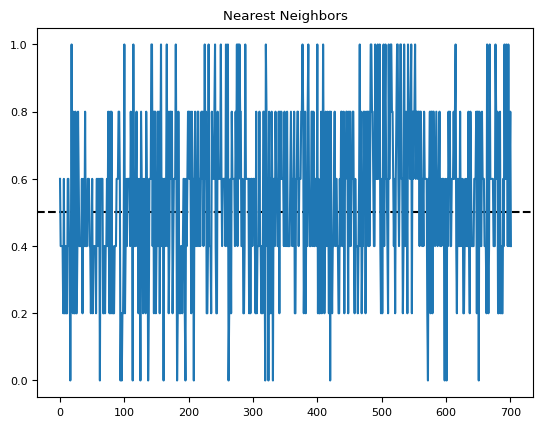

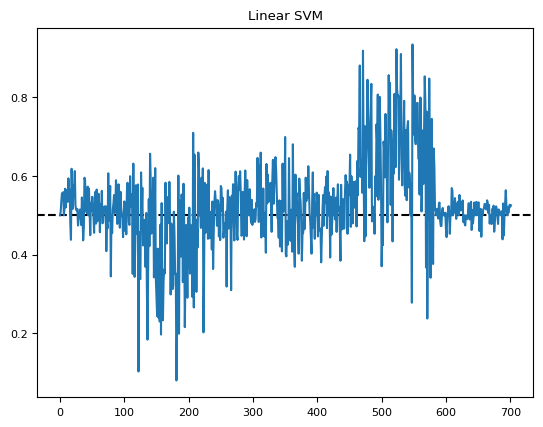

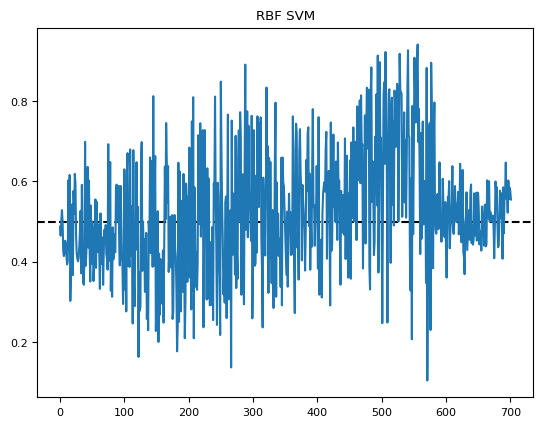

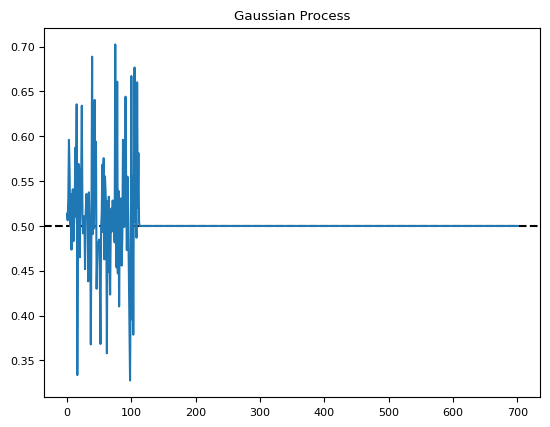

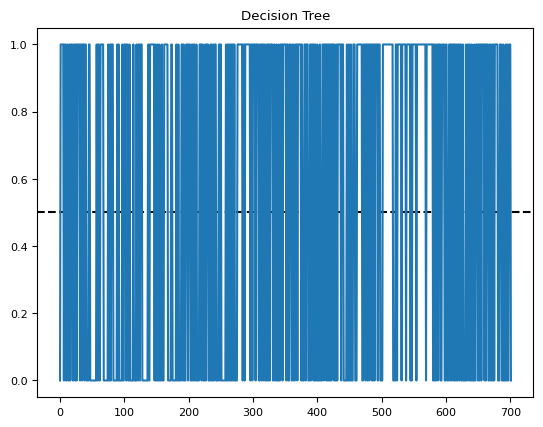

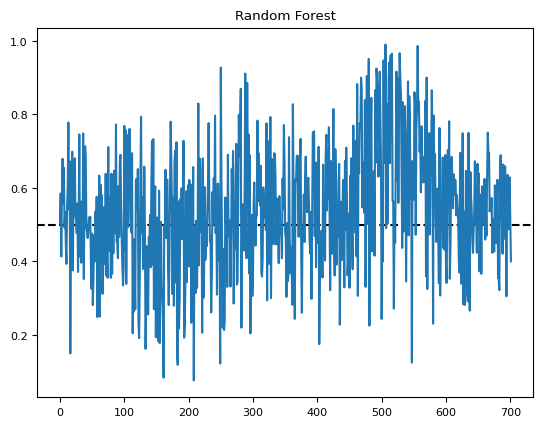

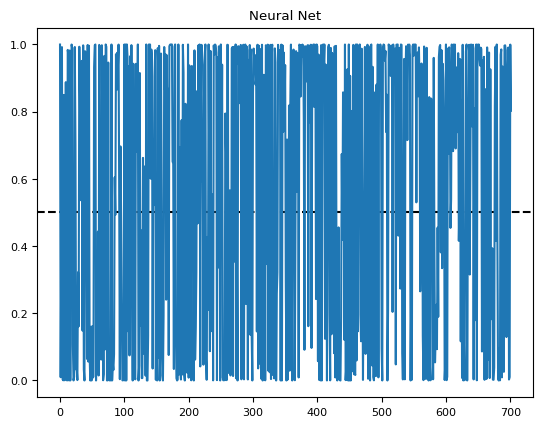

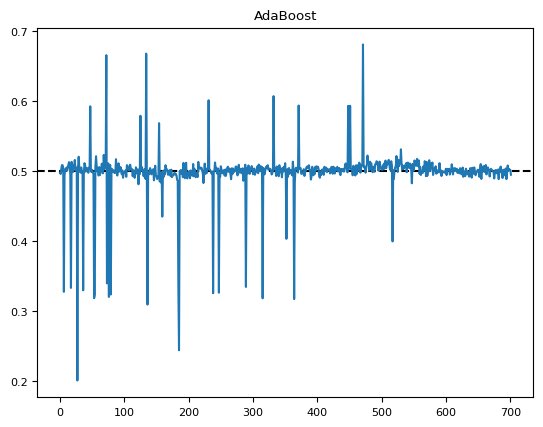

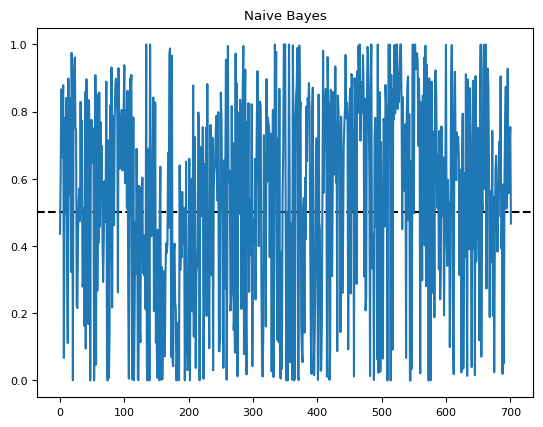

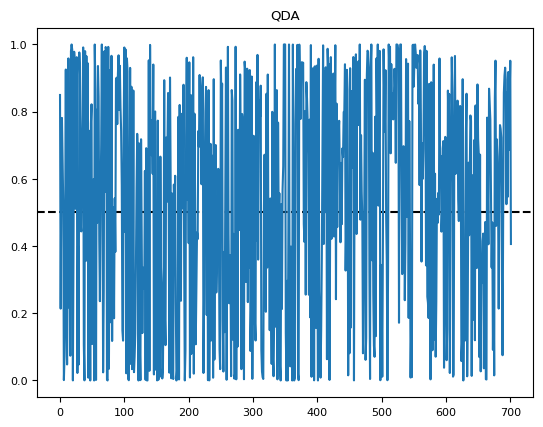

In [310]:

for alg in decoder_results.keys():
    fig,ax=plt.subplots()
    ax.axhline(0.5,color='k',linestyle='--')
    ax.plot(decoder_results[alg]['y_predict_proba'][:,0],label=alg)

    ax.set_title(alg)


In [3]:
#random blocks
rng = np.random.default_rng()

n_repeats=1000
n_blocks=np.zeros(n_repeats)
all_blocks=[]

min_n_trial_repeats=12
max_n_trial_repeats=60

for nn in range(0,n_repeats):

    random_block_length = []

    ntrials=len(session.trials[:])
    
    trialnum=0
    while trialnum<=ntrials:
        random_block_length.append(rng.integers(low=min_n_trial_repeats, high=max_n_trial_repeats, size=1)*4)
        trialnum=np.sum(random_block_length)

    if sum(random_block_length)>ntrials:
        random_block_length[-1]=random_block_length[-1]-(sum(random_block_length)-ntrials)
    
    all_blocks.append(np.hstack(random_block_length))
    n_blocks[nn]=len(random_block_length)


NameError: name 'session' is not defined

In [350]:
np.mean(n_blocks)

5.52

(array([ 61.,  67.,  70.,  54.,  41.,  56., 301., 237., 239., 246., 246.,
        258., 247., 213., 207., 242., 230., 209., 192., 208., 209., 210.,
        229., 183., 164., 211., 177., 187., 232.]),
 array([  0.,   8.,  16.,  24.,  32.,  40.,  48.,  56.,  64.,  72.,  80.,
         88.,  96., 104., 112., 120., 128., 136., 144., 152., 160., 168.,
        176., 184., 192., 200., 208., 216., 224., 232.]),
 <BarContainer object of 29 artists>)

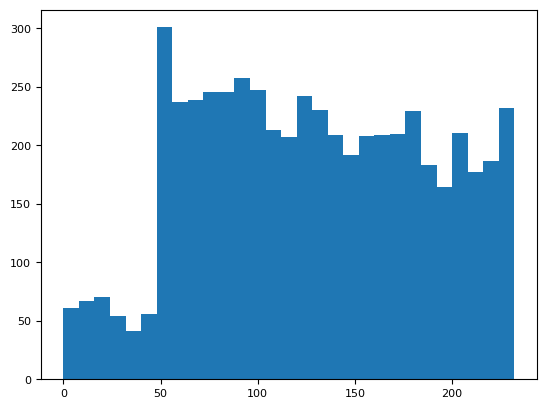

In [351]:
fig,ax=plt.subplots(1,1)
ax.hist(np.hstack(all_blocks),bins=np.arange(0,240,8))

In [27]:
#random block duration

n_repeats=1000
n_blocks=np.zeros(n_repeats)
session_duration=np.zeros(n_repeats)
all_blocks=[]

mean_n_seconds=600
std_n_seconds=120

min_duration_seconds=3600
max_duration_seconds=3600

for nn in range(0,n_repeats):

    random_block_duration = []
    
    total_duration_seconds=0
    while total_duration_seconds<=max_duration_seconds:
        temp_block_duration=np.random.default_rng().normal(mean_n_seconds, std_n_seconds, 1)

        random_block_duration.append(temp_block_duration)
        total_duration_seconds=np.sum(random_block_duration)

        if total_duration_seconds>min_duration_seconds:
            break

    if sum(random_block_duration)>max_duration_seconds:
        random_block_duration[-1]=random_block_duration[-1]-(sum(random_block_duration)-max_duration_seconds)
    
    total_duration_seconds=np.sum(random_block_duration)

    all_blocks.append(np.hstack(random_block_duration))
    session_duration[nn]=total_duration_seconds
    n_blocks[nn]=len(random_block_duration)



In [28]:
np.mean(n_blocks)
np.mean(np.hstack(all_blocks))

553.4204458109147

(array([ 81.,  68.,  74.,  78., 100., 129., 151., 221., 384., 561., 788.,
        929., 928., 784., 549., 353., 211.,  76.,  23.,  17.]),
 array([3.91105219e-01, 4.95866462e+01, 9.87821873e+01, 1.47977728e+02,
        1.97173269e+02, 2.46368810e+02, 2.95564351e+02, 3.44759892e+02,
        3.93955433e+02, 4.43150974e+02, 4.92346515e+02, 5.41542056e+02,
        5.90737598e+02, 6.39933139e+02, 6.89128680e+02, 7.38324221e+02,
        7.87519762e+02, 8.36715303e+02, 8.85910844e+02, 9.35106385e+02,
        9.84301926e+02]),
 <BarContainer object of 20 artists>)

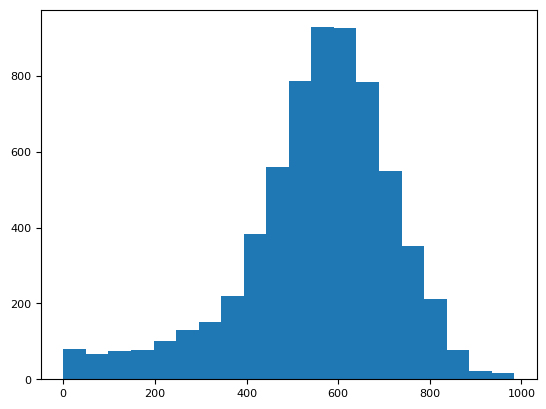

In [29]:
fig,ax=plt.subplots(1,1)
ax.hist(np.hstack(all_blocks),bins=20)

(array([  0.,  41.,   0.,   0.,   0.,   0.,   0., 923.,   0.,   0.,   0.,
          0.,   0.,   0.,  35.,   0.,   0.,   0.,   0.,   1.]),
 array([3600., 3600., 3600., 3600., 3600., 3600., 3600., 3600., 3600.,
        3600., 3600., 3600., 3600., 3600., 3600., 3600., 3600., 3600.,
        3600., 3600., 3600.]),
 <BarContainer object of 20 artists>)

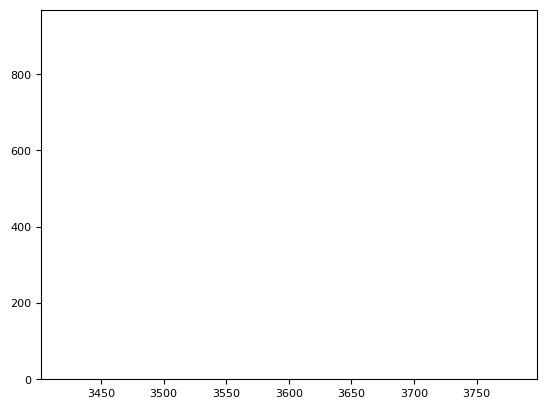

In [30]:
fig,ax=plt.subplots(1,1)
ax.hist(session_duration,bins=20)

(array([ 1.,  1.,  0.,  1.,  0.,  1.,  2.,  6.,  4.,  6.,  4., 15., 14.,
        10., 11., 12.,  6.,  2.,  1.,  3.]),
 array([ 20.74653197,  66.13906506, 111.53159815, 156.92413125,
        202.31666434, 247.70919743, 293.10173052, 338.49426361,
        383.8867967 , 429.27932979, 474.67186288, 520.06439598,
        565.45692907, 610.84946216, 656.24199525, 701.63452834,
        747.02706143, 792.41959452, 837.81212761, 883.20466071,
        928.5971938 ]),
 <BarContainer object of 20 artists>)

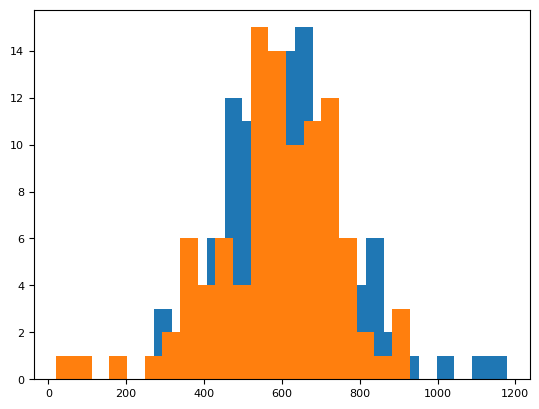

In [45]:
mean_n_seconds=600
std_n_seconds=150

#min = 200 sec; max = 1000 sec

s = np.random.default_rng().normal(mean_n_seconds, std_n_seconds, 100)
t = 600 + 600-s
fig,ax=plt.subplots(1,1)
ax.hist(s,bins=20)
ax.hist(t,bins=20)

(array([ 2.,  0.,  1.,  0.,  5.,  7., 10., 21., 21., 33., 33., 21., 21.,
        10.,  7.,  5.,  0.,  1.,  0.,  2.]),
 array([  20.74653197,   78.67187877,  136.59722558,  194.52257238,
         252.44791918,  310.37326599,  368.29861279,  426.22395959,
         484.14930639,  542.0746532 ,  600.        ,  657.9253468 ,
         715.85069361,  773.77604041,  831.70138721,  889.62673401,
         947.55208082, 1005.47742762, 1063.40277442, 1121.32812123,
        1179.25346803]),
 <BarContainer object of 20 artists>)

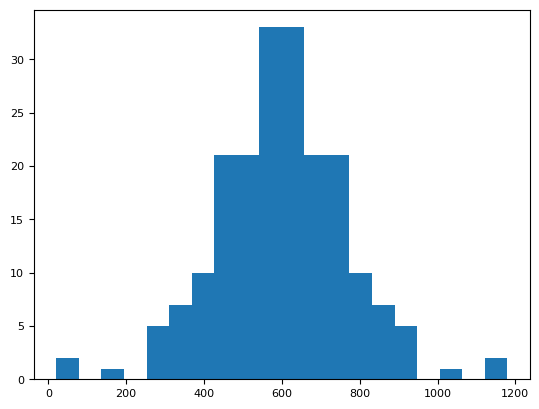

In [46]:
fig,ax=plt.subplots(1,1)
ax.hist(np.hstack([s,t]),bins=20)

(array([ 32.,  44.,  78.,  74.,  86., 131., 122., 150., 143., 140., 140.,
        143., 150., 122., 131.,  86.,  74.,  78.,  44.,  32.]),
 array([200.50845407, 210.45760866, 220.40676325, 230.35591785,
        240.30507244, 250.25422703, 260.20338163, 270.15253622,
        280.10169081, 290.05084541, 300.        , 309.94915459,
        319.89830919, 329.84746378, 339.79661837, 349.74577297,
        359.69492756, 369.64408215, 379.59323675, 389.54239134,
        399.49154593]),
 <BarContainer object of 20 artists>)

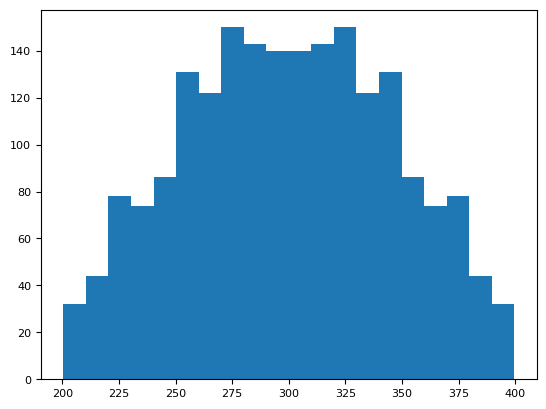

In [60]:
mean_n_seconds=300
std_n_seconds=60

min_block_duration=200
max_block_duration=1000

n_repeats=1000

all_blocks=[]

#min = 200 sec; max = 1000 sec
for ii in range(0,n_repeats):
    append=False
    while append==False:
        s = np.random.default_rng().normal(mean_n_seconds, std_n_seconds, 1)
        t = mean_n_seconds + mean_n_seconds-s
        if s>=min_block_duration and s<=max_block_duration and t>=min_block_duration and t<=max_block_duration:
            append=True
    
    all_blocks.append(s)
    all_blocks.append(t)

all_blocks=np.hstack(all_blocks)

fig,ax=plt.subplots(1,1)
ax.hist(all_blocks,bins=20)


In [53]:
# np.mean(np.vstack([s,t]),axis=0)
all_blocks

array([[427.31980922, 772.68019078, 302.59075764, ..., 567.49726022,
        309.99850671, 890.00149329]])

In [385]:
mean_n_seconds=600
std_n_seconds=60

np.random.default_rng().integers(low=0, high=1, size=12, endpoint=True)
# fig,ax=plt.subplots(1,1)
# ax.hist(s,bins=20)

array([0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1], dtype=int64)

In [400]:
blocks=np.array([0,0,0,0,0,0,1,1,1,1,1,1])

np.random.choice(blocks,len(blocks),replace=False)

array([1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1])

In [313]:
# skip_first_block=False
# train_by_set={}
# test_by_set={}
# train=[]
# test=[]

# block_numbers=np.unique(block_index)

# for crossval_set in range(0,5):
#     train_by_set[crossval_set]=[]
#     test_by_set[crossval_set]=[]

# for bb in block_numbers:
#     crossval_set=0
#     if skip_first_block:
#         if bb==0:
#             continue
#     block_inds=np.where(block_index==bb)[0]
#     skf = StratifiedKFold(n_splits=5,shuffle=True)
#     train_test_split = skf.split(input_data[block_inds], labels[block_inds])
#     for temp_train, temp_test in train_test_split:
#         train_by_set[crossval_set].append(block_inds[temp_train])
#         test_by_set[crossval_set].append(block_inds[temp_test])
#         crossval_set+=1

# for crossval_set in range(0,5):
#     train.append(np.hstack(train_by_set[crossval_set]))
#     test.append(np.hstack(test_by_set[crossval_set]))

# train_test_split=zip(train,test)


In [156]:
# fig,ax=plt.subplots()
# ax.plot(np.sort(np.hstack(train_trials)))

In [145]:
# train_test_split = skf.split(input_data, labels)
x=0
for train,test in train_test_split:
    print(x)
    x+=1
    print(train)
    print(test)

In [314]:
# train, test in train_test_split
# train, test in skf.split(input_data[block_inds], labels[block_inds])
# train

In [123]:

# temp_train, temp_test in train_test_split

5

In [51]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X)

PCA()

In [52]:
X_new = pca.transform(X)

(-1.0, 10.0)

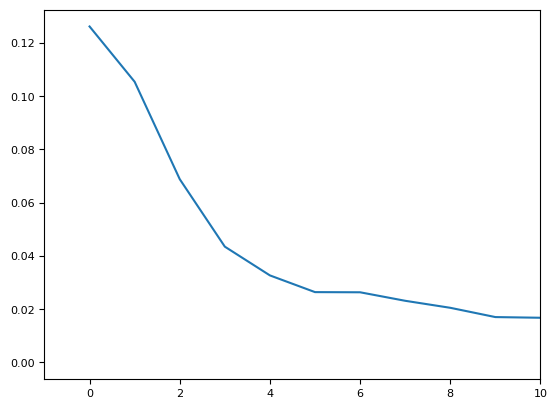

In [53]:
fig,ax=plt.subplots(1,1)
ax.plot(pca.explained_variance_ratio_)
ax.set_xlim([-1,10])

In [55]:
np.sum(pca.explained_variance_ratio_[:10])

0.49024174373760543

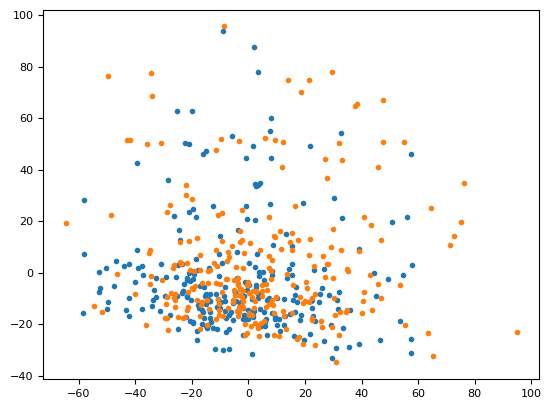

In [54]:
fig,ax=plt.subplots(1,1)

ax.plot(X_new[y=='vis',0],X_new[y=='vis',1],'.')
ax.plot(X_new[y=='aud',0],X_new[y=='aud',1],'.')

In [33]:
X_new.shape

(514, 514)

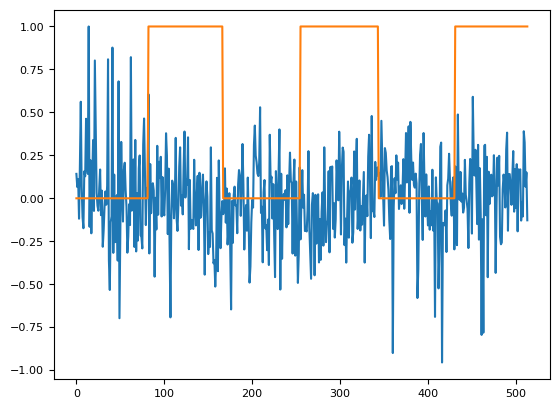

In [63]:
sel_component=7
fig,ax=plt.subplots(1,1)
ax.plot(X_new[:,sel_component]/np.max(X_new[:,sel_component]))
ax.plot(labels=='vis')

In [410]:
import pandas as pd
df=pd.read_excel(r"D:\DynamicRoutingTraining_Copy.xlsx", sheet_name = None)
for x, y in df.items():
    if x=='all mice':
        print('skipping mice summary sheet')
        continue
    print(x)
    print(y.query(('`task version`.str.contains("stage 1")')))
    # print(x)
    # print(y)

skipping mice summary sheet
dead


UndefinedVariableError: name 'BACKTICK_QUOTED_STRING_task_version' is not defined

In [416]:
keys=list(df.keys())
keys[0]

'all mice'

In [413]:
df['614910']

,start time,rig name,task version,hits,d' same modality,d' other modality go stim,pass,ignore
0,2022-03-29 17:15:58,B1,stage 0,[0],[nan],[nan],1,0
1,2022-03-30 16:08:32,B1,stage 1,[74],[0.3],[nan],0,0
2,2022-03-31 15:24:31,B1,stage 1,[99],[0.58],[nan],0,0
3,2022-04-01 14:55:40,B1,stage 1,[132],[1.74],[nan],0,0
4,2022-04-04 13:22:02,B1,stage 1,[172],[1.39],[nan],0,0
5,2022-04-05 13:59:15,B1,stage 1,[190],[1.87],[nan],0,0
6,2022-04-06 13:55:21,B1,stage 2,[57],[-0.26],[nan],0,0
7,2022-04-07 14:10:33,B1,stage 2,[124],[1.77],[nan],0,0
8,2022-04-08 16:04:15,B1,stage 2,[211],[2.72],[nan],0,0
9,2022-04-12 14:10:44,B1,stage 2,[231],[3.65],[nan],1,0


In [161]:
loadpath=r"\\allen\programs\mindscope\workgroups\templeton\TTOC\decoding results\forecasting"
decoder_results=os.listdir(loadpath)

In [162]:
decoder_results

['620263_2022-07-26_0_forecasting.pkl',
 '636766_2023-01-23_0_forecasting.pkl',
 '636766_2023-01-24_0_forecasting.pkl',
 '636766_2023-01-25_0_forecasting.pkl',
 '636766_2023-01-26_0_forecasting.pkl',
 '644864_2023-01-30_0_forecasting.pkl',
 '644864_2023-01-31_0_forecasting.pkl',
 '644864_2023-02-01_0_forecasting.pkl',
 '644864_2023-02-02_0_forecasting.pkl',
 '644866_2023-02-07_0_forecasting.pkl',
 '644866_2023-02-08_0_forecasting.pkl',
 '644866_2023-02-09_0_forecasting.pkl',
 '644866_2023-02-10_0_forecasting.pkl',
 '644867_2023-02-20_0_forecasting.pkl',
 '644867_2023-02-22_0_forecasting.pkl',
 '644867_2023-02-23_0_forecasting.pkl',
 '649943_2023-02-13_0_forecasting.pkl',
 '649943_2023-02-14_0_forecasting.pkl',
 '649943_2023-02-15_0_forecasting.pkl',
 '649943_2023-02-16_0_forecasting.pkl',
 '660023_2023-08-09_0_forecasting.pkl',
 '662892_2023-08-21_0_forecasting.pkl',
 '662892_2023-08-22_0_forecasting.pkl',
 '662892_2023-08-23_0_forecasting.pkl',
 '662892_2023-08-24_0_forecasting.pkl',


In [149]:
# svc_results=np.load(os.path.join(loadpath,decoder_results[0]),allow_pickle=True).item()

with open(os.path.join(loadpath,decoder_results[5]),'rb') as handle:
    svc_results=pickle.load(handle)
    

In [179]:
svc_results.keys()

dict_keys(['trial_numbers', 'unit_numbers', 'min_n_units', 'n_repeats', 'time_bins', 'spikes_time_before', 'spikes_time_after', 'spikes_binsize', 'decoder_time_before', 'decoder_time_after', 'decoder_binsize', 'balance_labels', 'crossval', 'all_areas', 'labels_as_index', 'decoder_type', 'generate_labels', 'block_ids', 'crossval_index'])

In [150]:
svc_results['block_ids']['all'][0][0][0].keys()

dict_keys(['cr', 'pred_label', 'true_label', 'pred_label_all', 'trials_used', 'decision_function', 'decision_function_all', 'coefs', 'classes', 'intercept', 'params', 'balanced_accuracy', 'pred_label_train', 'true_label_train', 'cr_train', 'balanced_accuracy_train', 'train_trials', 'test_trials', 'models', 'scaler', 'label_names', 'labels', 'shuffle', 'trial_sel_idx', 'unit_sel_idx'])

In [175]:
svc_results['block_ids'].keys()

dict_keys(['all', 'MOp_probeF', 'MOs', 'CP_probeA', 'DG_probeD', 'VISl', 'MB_probeB', 'VISp_probeB', 'CA1_probeE', 'CA1_probeC', 'MOp_probeA', 'CP_probeF', 'DG_probeC', 'VISp_probeC', 'SUB', 'LSr', 'VISpor', 'MGv_probeC'])

In [160]:
svc_results['block_ids']['MOp_probeA'][0][0][0]['balanced_accuracy']

0.13145053475935828

In [170]:
sel_area='ORBl'

test_idx=svc_results['block_ids'][sel_area][0][0][0]['test_trials']
train_idx=svc_results['block_ids'][sel_area][0][0][0]['train_trials']

pred_label_all=svc_results['block_ids'][sel_area][0][0][0]['pred_label_all']
dec_func_all=svc_results['block_ids'][sel_area][0][0][0]['decision_function_all']
true_label=svc_results['block_ids'][sel_area][0][0][0]['true_label']



KeyError: 'ORBl'

In [165]:
true_label_all=[]
for tt in test_idx:
    true_label_all.append(true_label[tt])

In [169]:
balanced_accuracy_score(np.hstack(true_label_all),np.hstack(pred_label_all))

0.6593822046813334

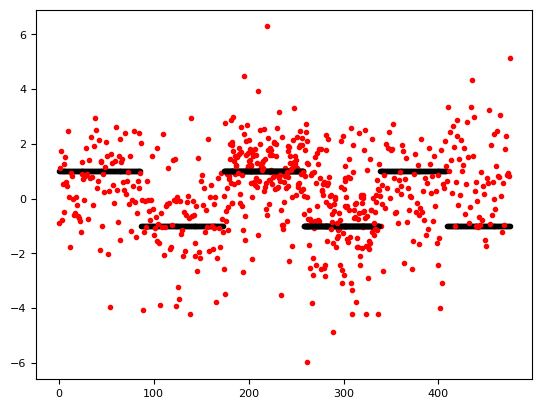

In [144]:
fig,ax=plt.subplots(1,1)

for xx in range(len(test_idx)):
    ax.plot(test_idx[xx],true_label[test_idx[xx]]*2-1,'k.')
    ax.plot(test_idx[xx],dec_func_all[xx],'r.')
    

In [250]:
loadpath=r"\\allen\programs\mindscope\workgroups\templeton\TTOC\decoding results\forecasting_3"
decoder_results=os.listdir(loadpath)

In [251]:
decoder_accuracy_table={
    'session_id':[],
    'project':[],
    'area':[],
    'probe':[],
    'n_units':[],
    'balanced_accuracy':[],
}

#loop through loaded sessions
for xx in range(len(decoder_results)):

    #load session  
    with open(os.path.join(loadpath,decoder_results[xx]),'rb') as handle:
        svc_results=pickle.load(handle)

    session_info=npc_lims.get_session_info(decoder_results[xx][:17])

    #find accuracy for all test blocks for each area

    #loop through areas
    areas=list(svc_results['block_ids'].keys())
    for sel_area in areas:
        test_idx=svc_results['block_ids'][sel_area][0][0][0]['test_trials']
        # train_idx=svc_results['block_ids'][sel_area][0][0][0]['train_trials']
        pred_label_all=svc_results['block_ids'][sel_area][0][0][0]['pred_label_all']
        # dec_func_all=svc_results['block_ids'][sel_area][0][0][0]['decision_function_all']
        true_label=svc_results['block_ids'][sel_area][0][0][0]['true_label']

        true_label_all=[]
        for tt in test_idx:
            true_label_all.append(true_label[tt])

        #split area and probe
        if '_' in sel_area:
            area,probe=sel_area.split('_')
        else:
            area=sel_area
            probe=''

        decoder_accuracy_table['session_id'].append(session_info.id)
        decoder_accuracy_table['project'].append(session_info.project)
        decoder_accuracy_table['area'].append(area)
        decoder_accuracy_table['probe'].append(probe)
        decoder_accuracy_table['n_units'].append(svc_results['block_ids'][sel_area]['n_units'])
        decoder_accuracy_table['balanced_accuracy'].append(balanced_accuracy_score(np.hstack(true_label_all),np.hstack(pred_label_all)))
    

In [247]:
decoder_results[xx][:17]

'681532_2023-10-18'

In [252]:
decoder_accuracy_df=pd.DataFrame(decoder_accuracy_table)
decoder_accuracy_df

,session_id,project,area,probe,n_units,balanced_accuracy
0,620263_2022-07-26,TempletonPilotSession,all,,1026,0.045936
1,620263_2022-07-26,TempletonPilotSession,CA1,probeC,163,0.093215
2,620263_2022-07-26,TempletonPilotSession,ACAv,,152,0.141413
3,620263_2022-07-26,TempletonPilotSession,DG,,128,0.144902
4,620263_2022-07-26,TempletonPilotSession,TEa,,124,0.134778
...,...,...,...,...,...,...
997,681532_2023-10-18,DynamicRouting,DG,probeD,46,0.380929
998,681532_2023-10-18,DynamicRouting,ProS,probeD,42,0.341876
999,681532_2023-10-18,DynamicRouting,POL,,42,0.393402
1000,681532_2023-10-18,DynamicRouting,DG,probeB,42,0.315133


C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_5036\2739560123.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,ax=plt.subplots(1,1)


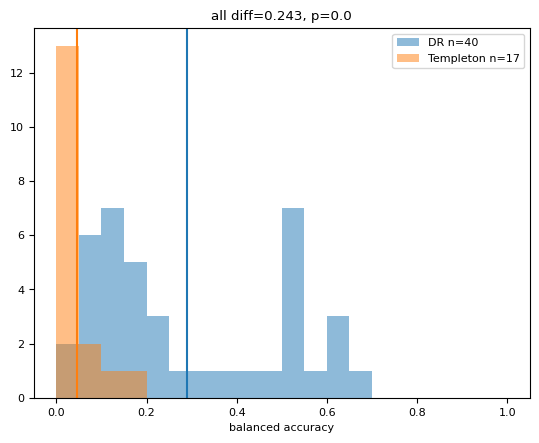

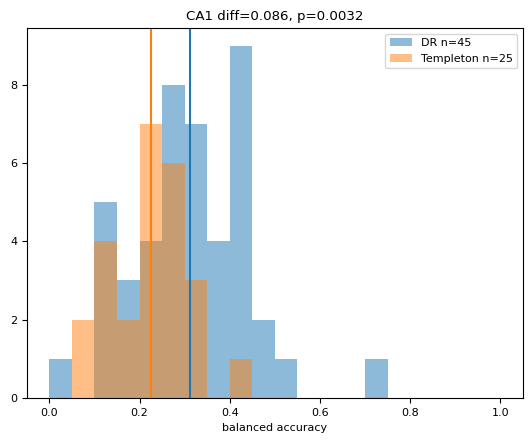

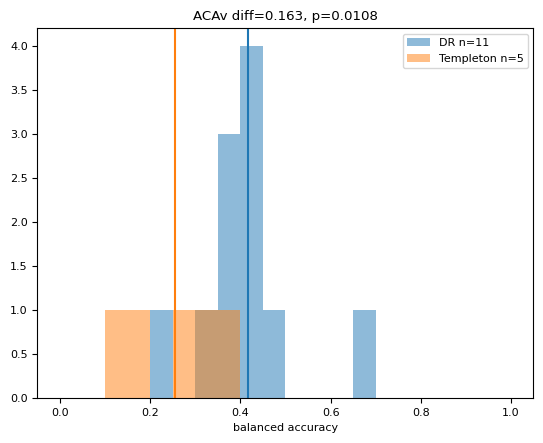

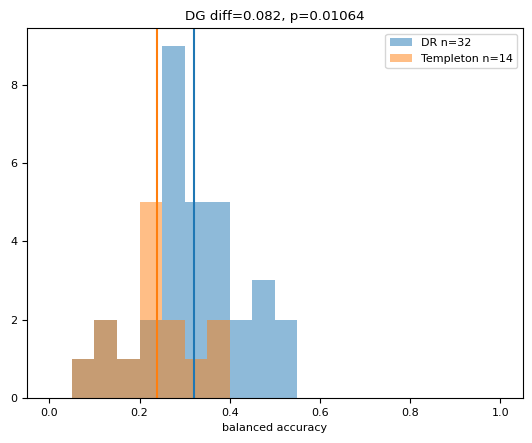

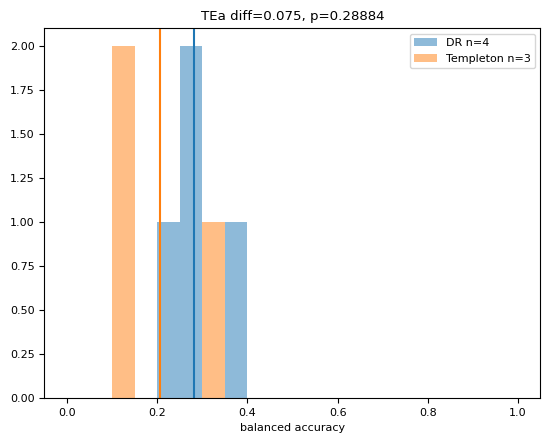

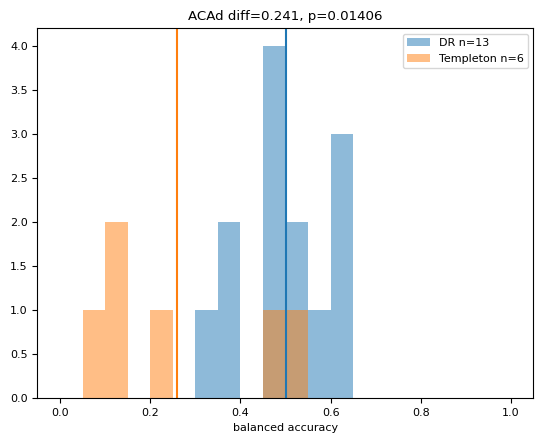

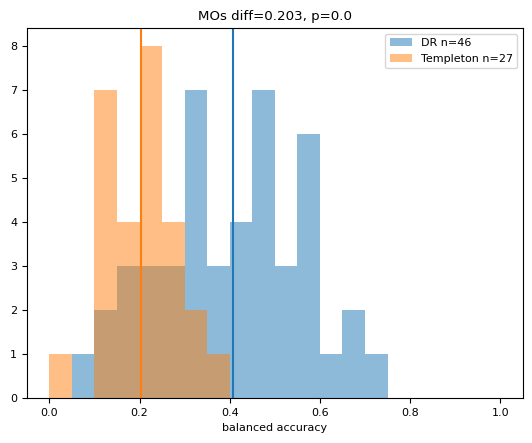

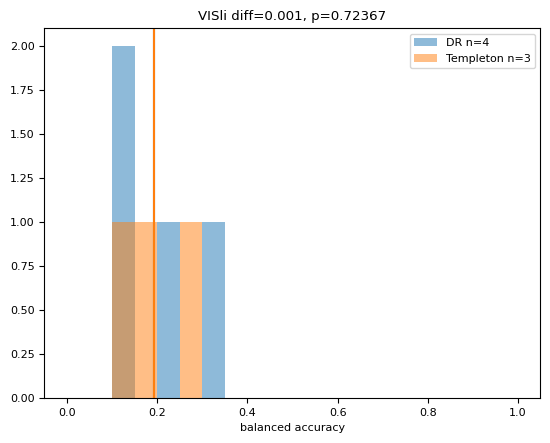

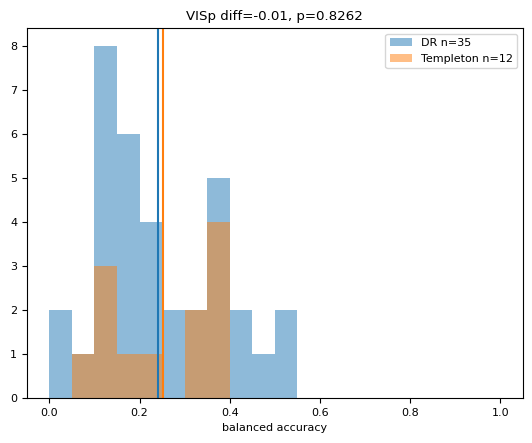

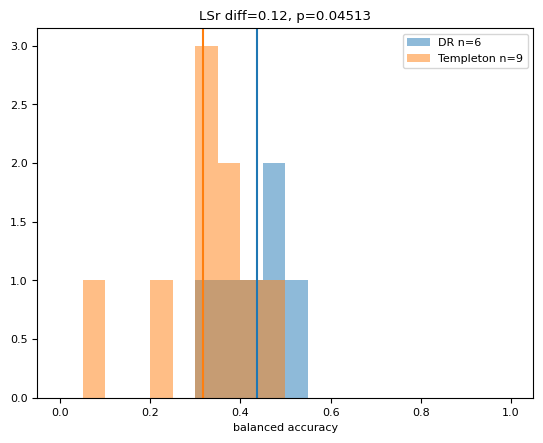

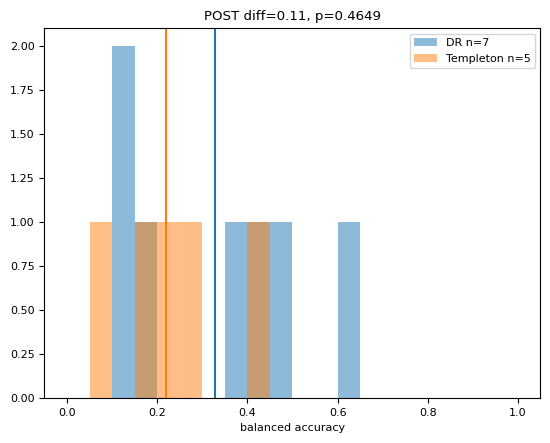

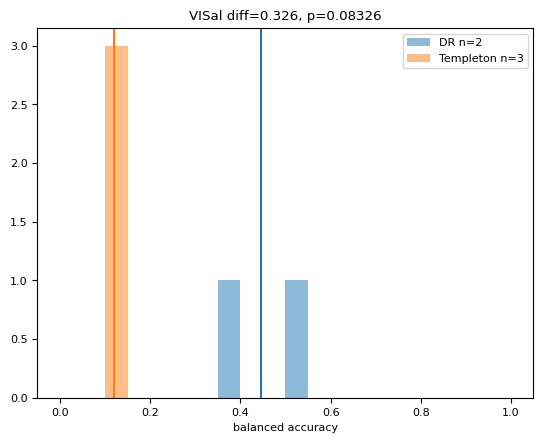

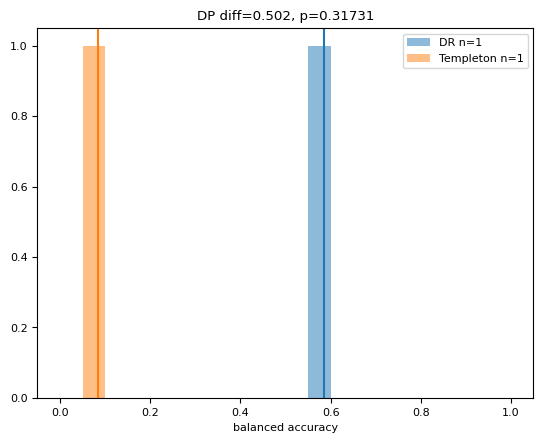

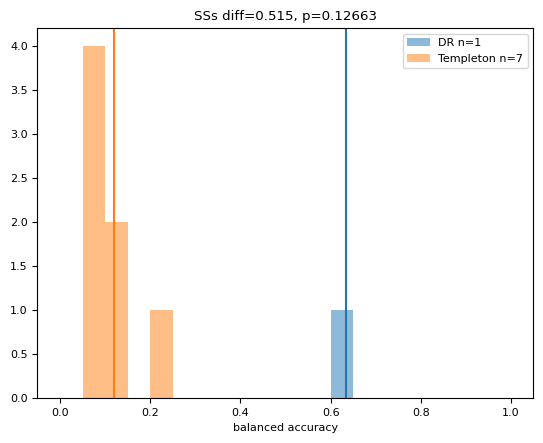

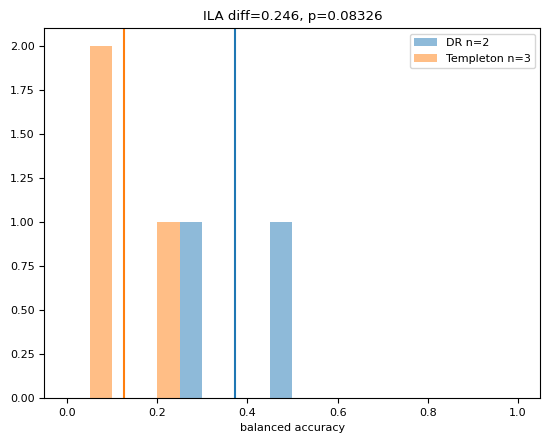

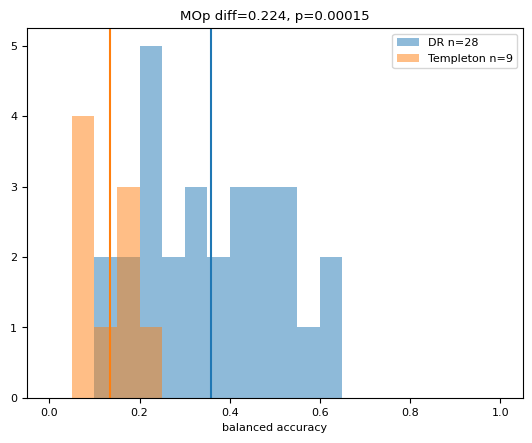

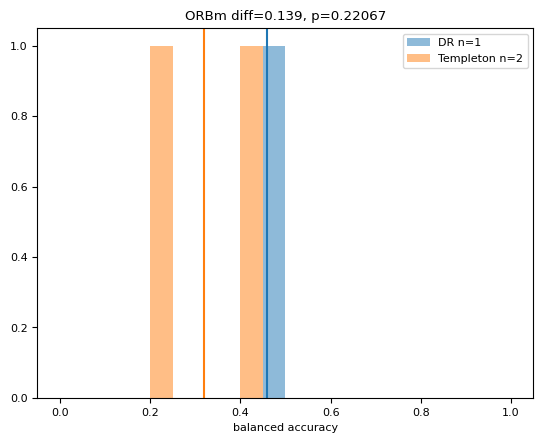

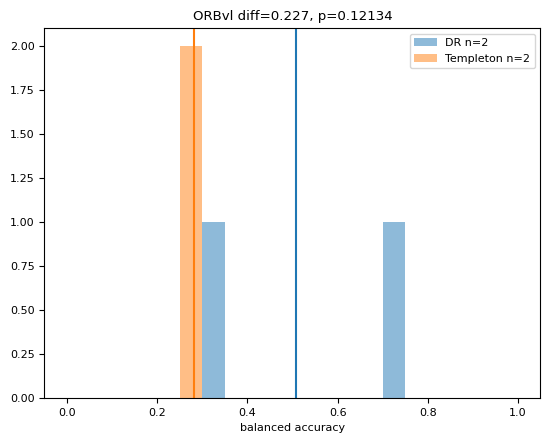

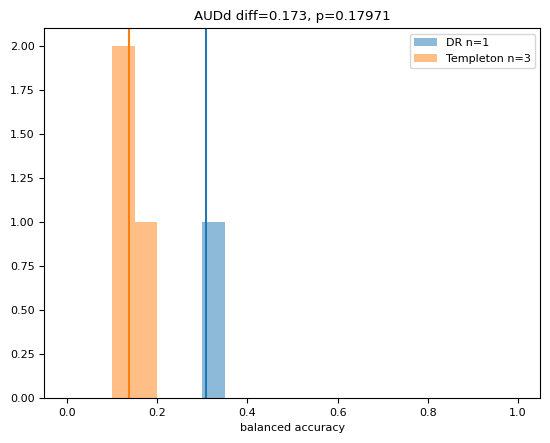

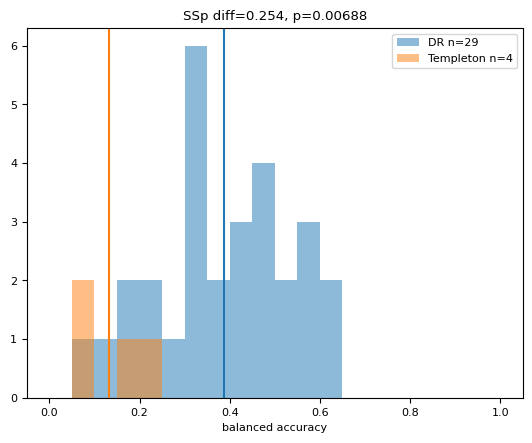

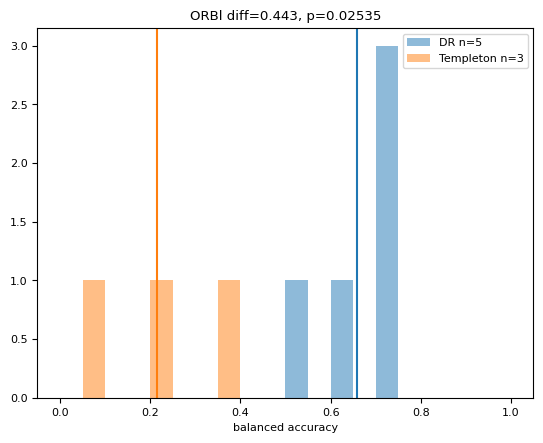

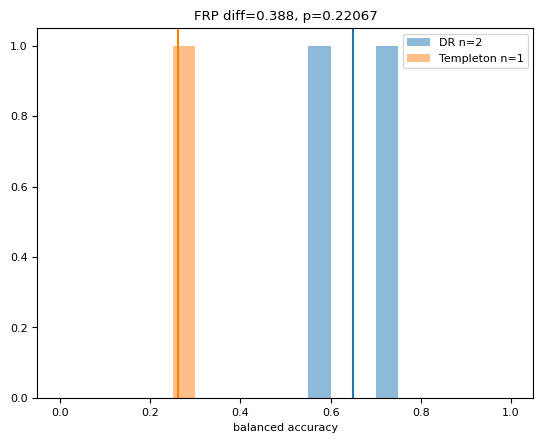

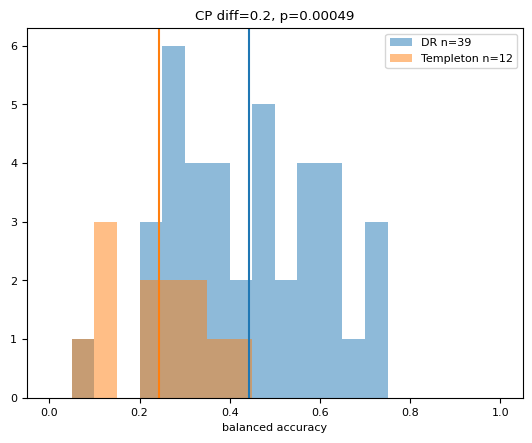

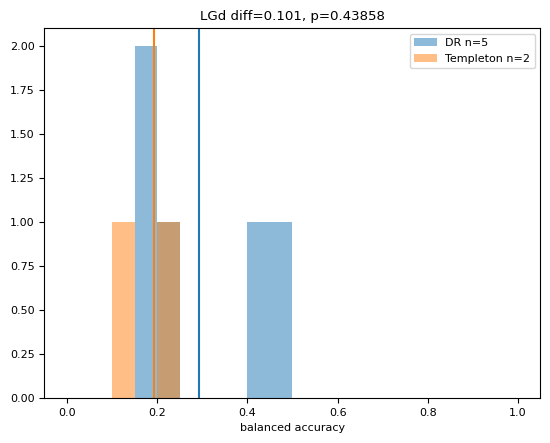

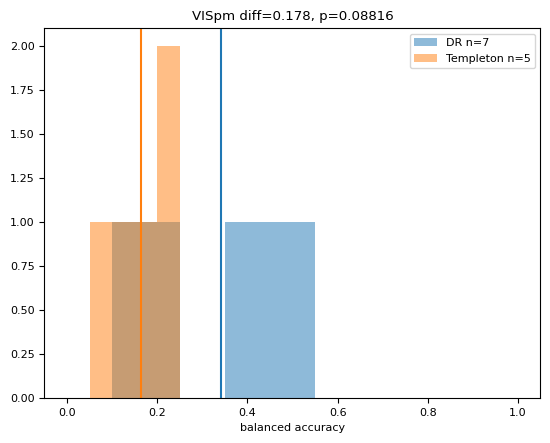

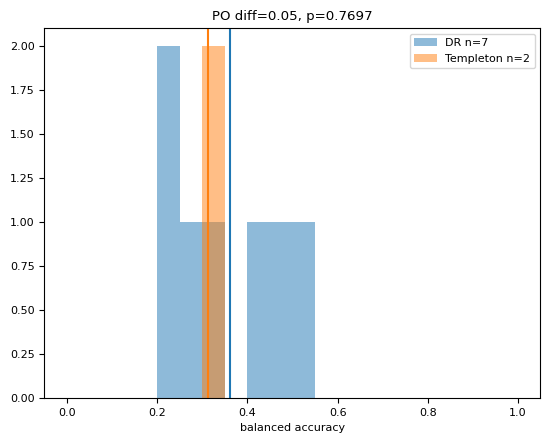

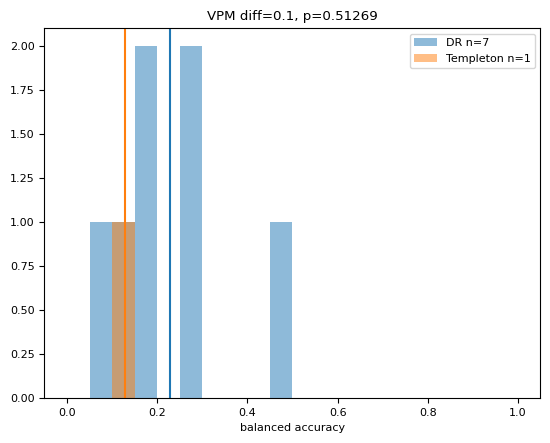

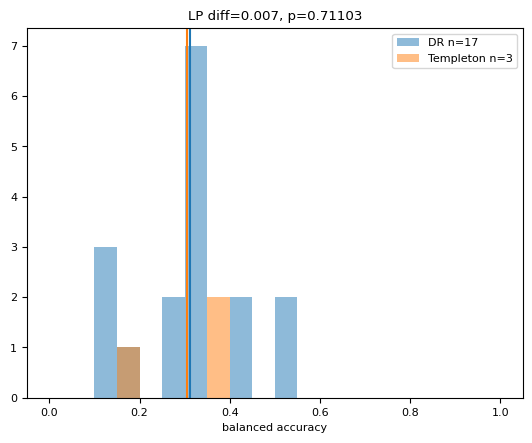

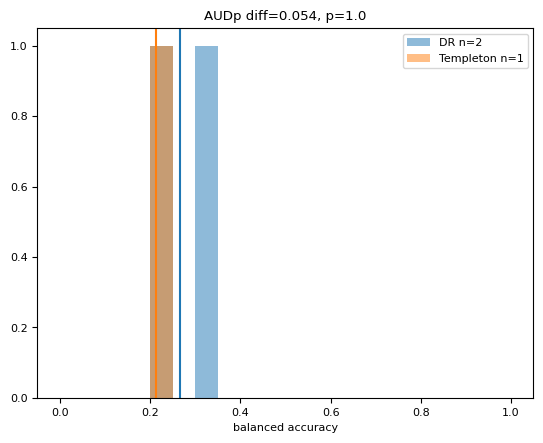

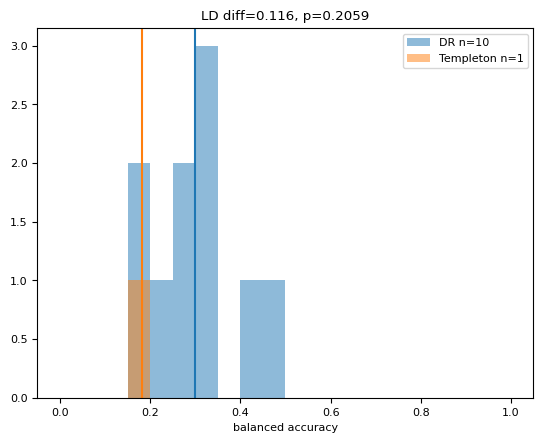

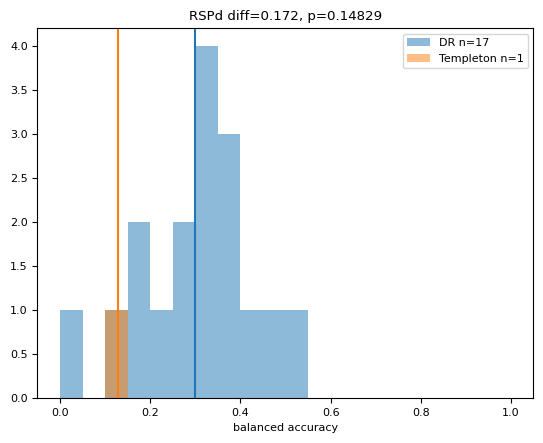

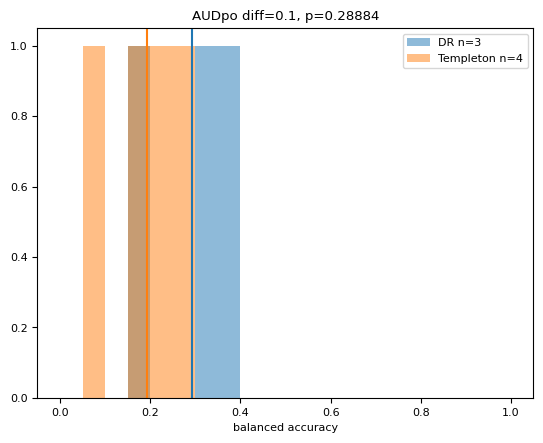

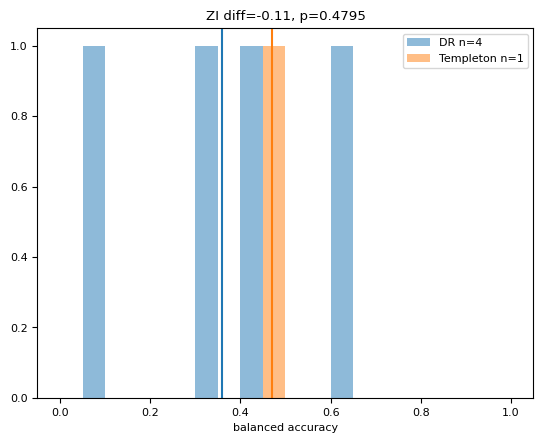

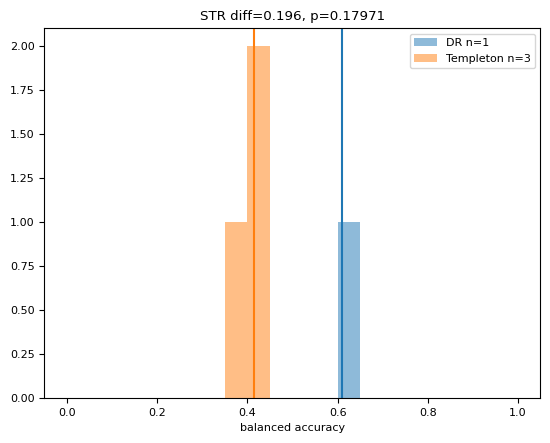

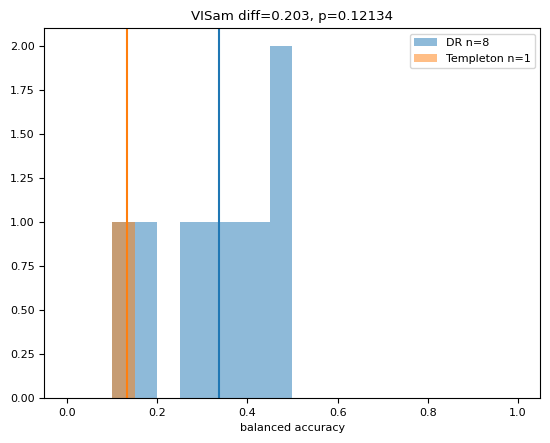

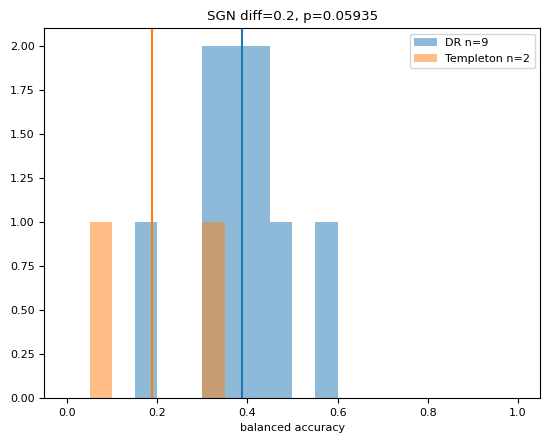

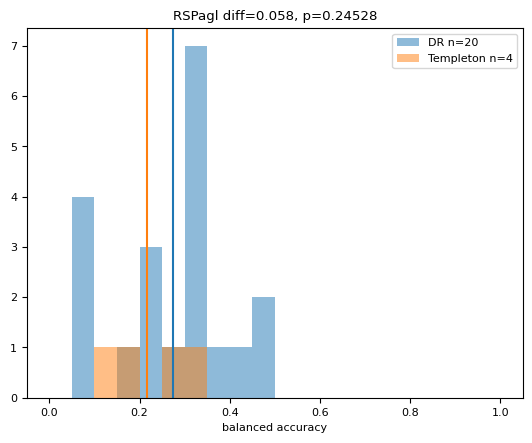

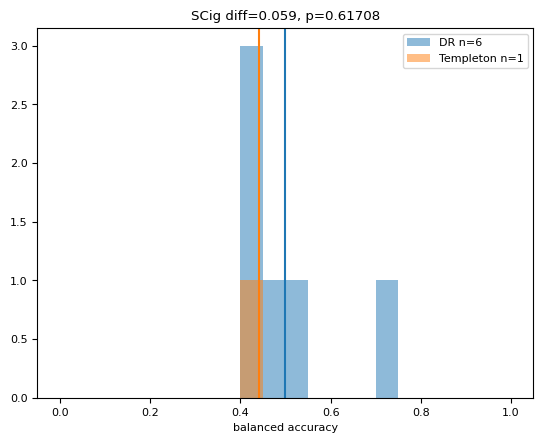

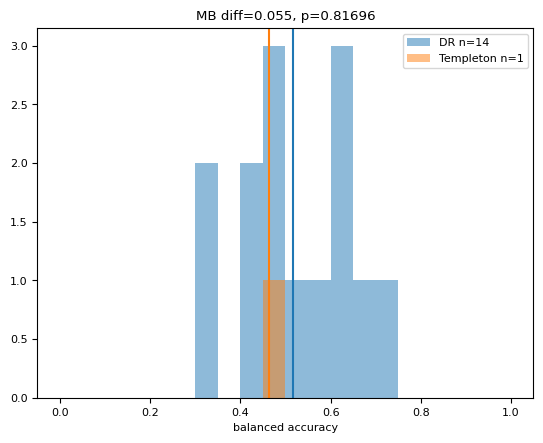

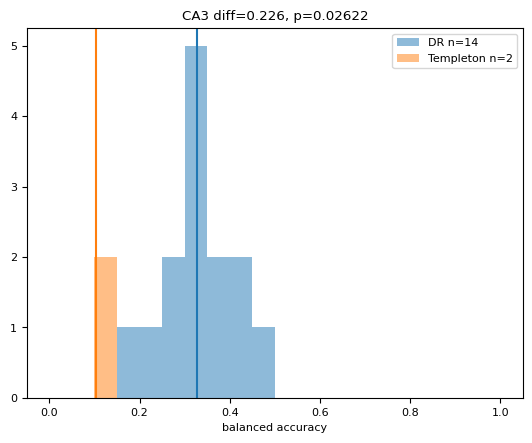

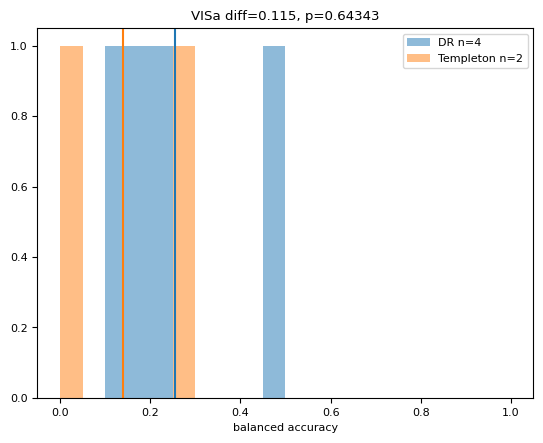

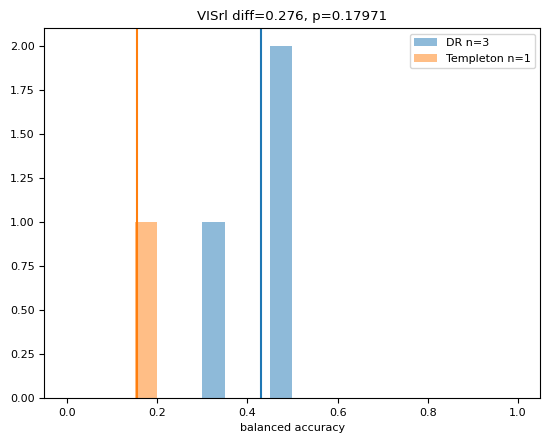

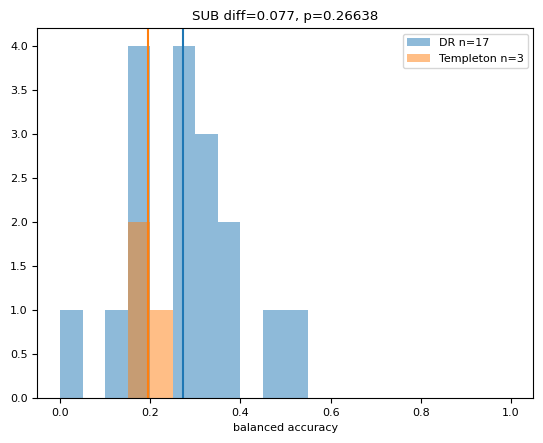

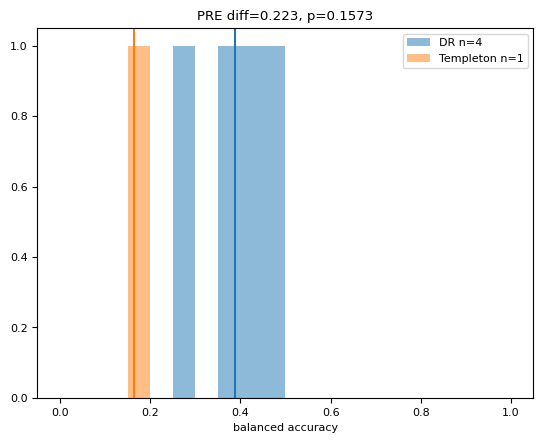

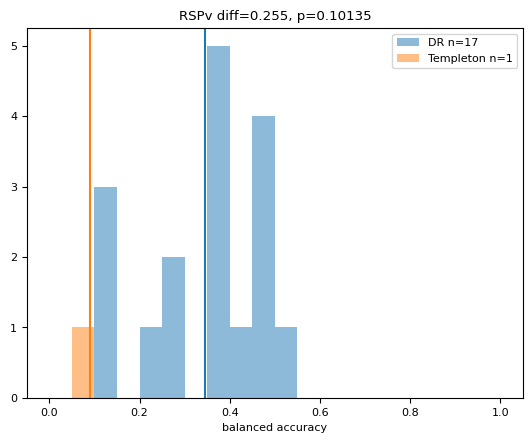

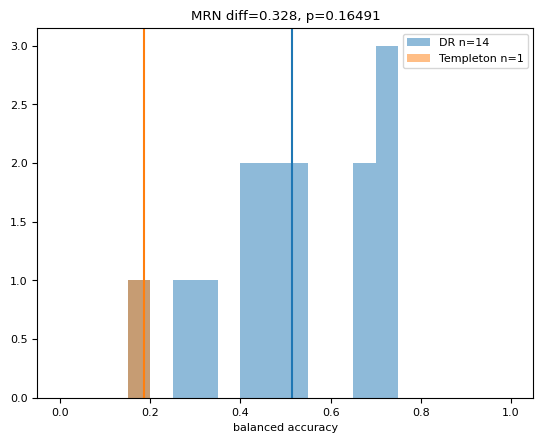

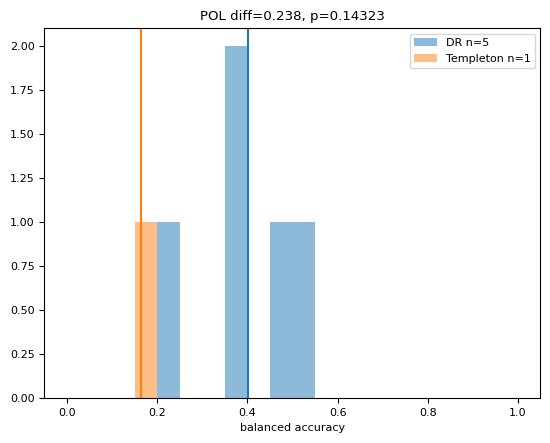

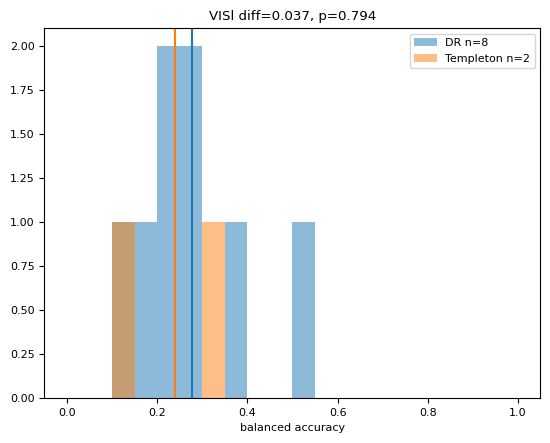

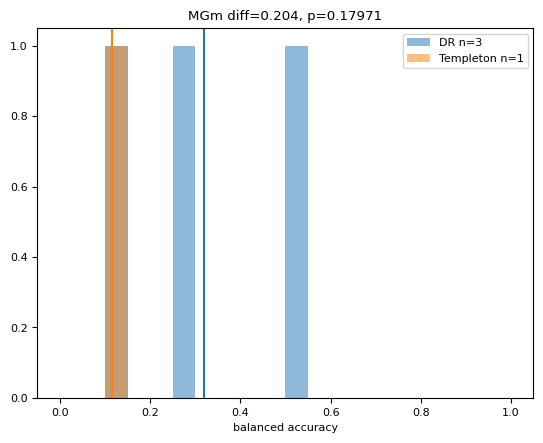

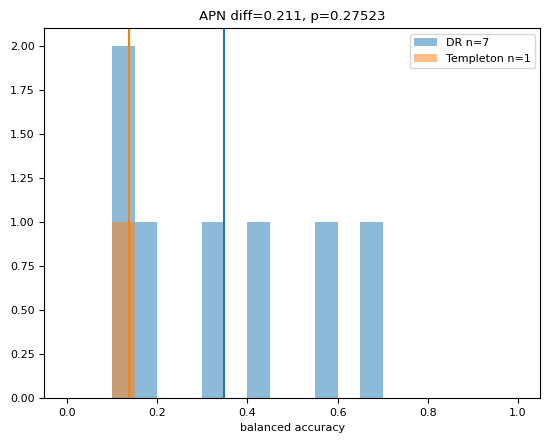

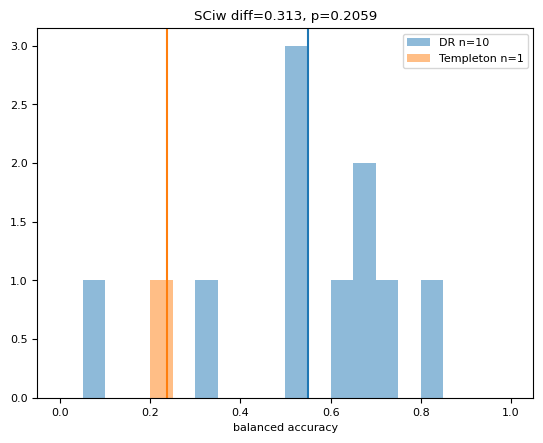

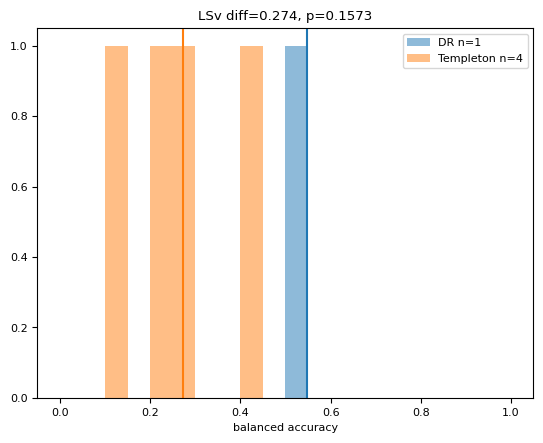

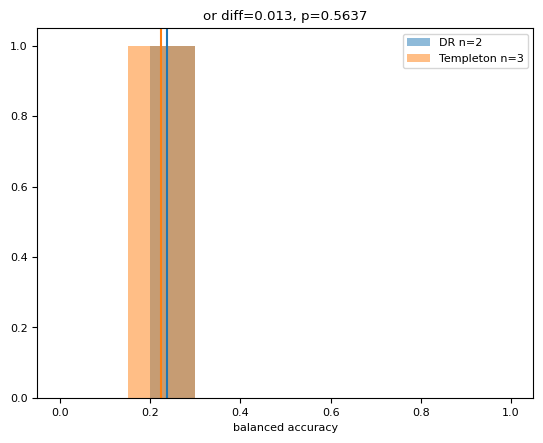

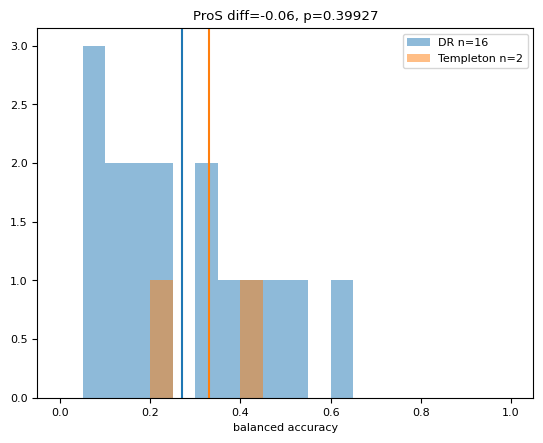

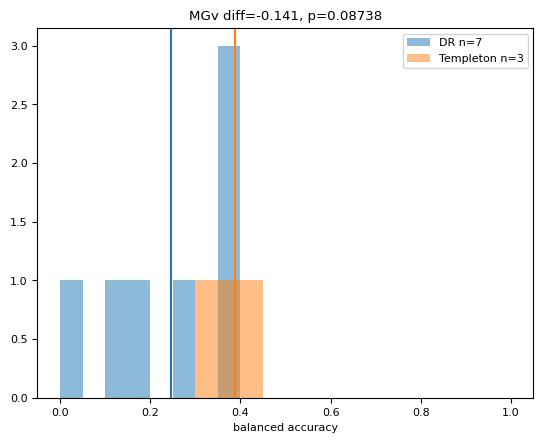

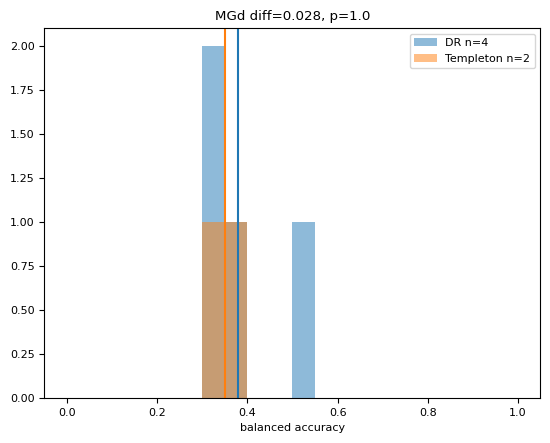

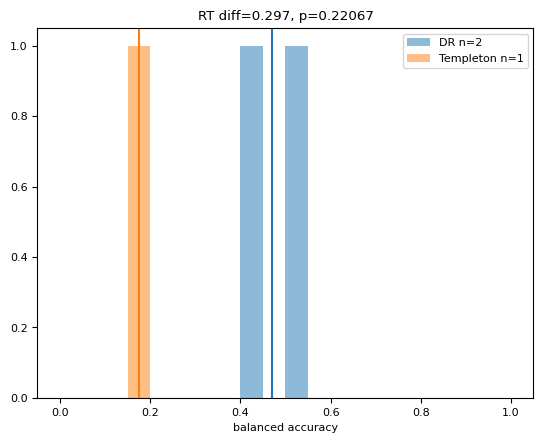

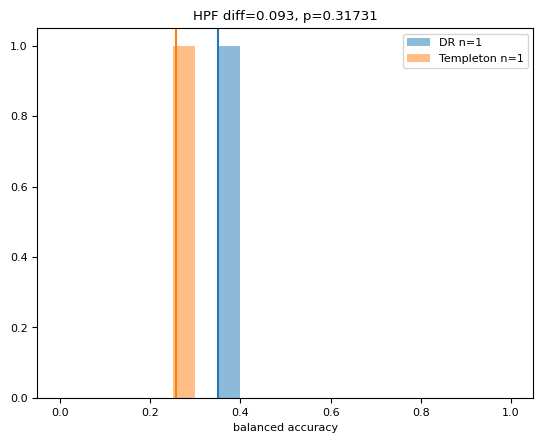

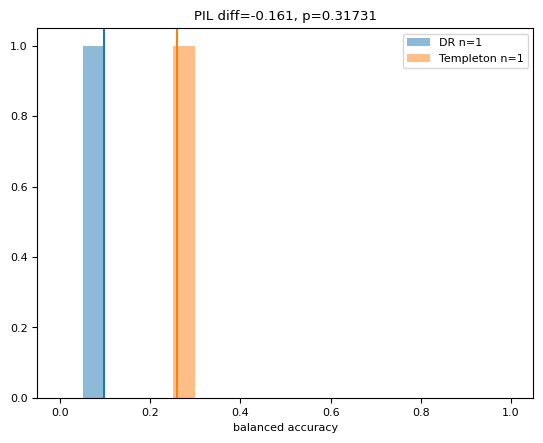

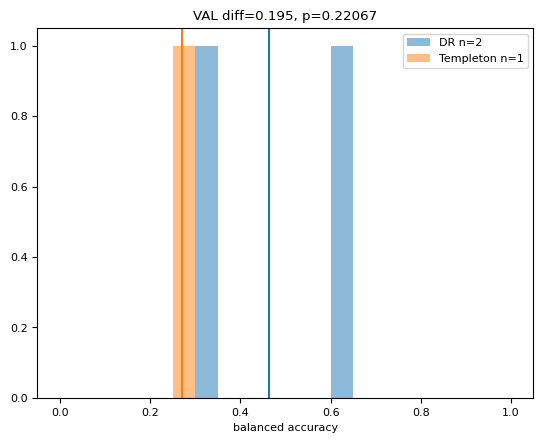

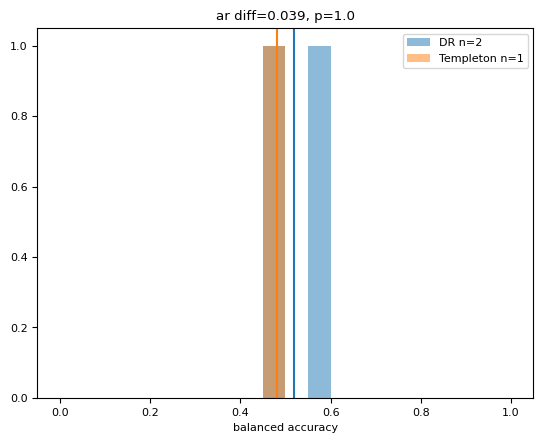

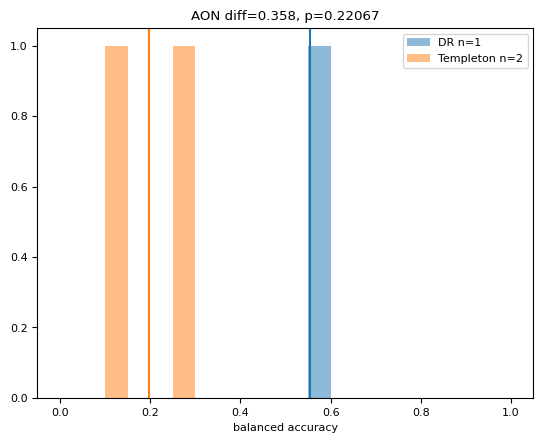

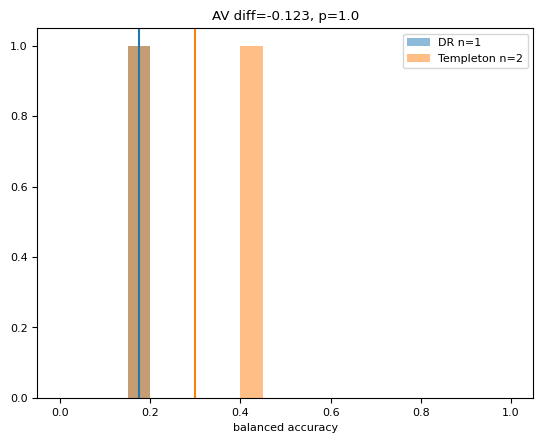

In [253]:
all_areas=decoder_accuracy_df['area'].unique()
xbins=np.arange(0,1.05,0.05)

area_dr_templ_diff={
    'area':[],
    'diff':[],
    'p':[],
    'dr_n':[],
    'templ_n':[],
}

for aa in all_areas[:]:
    # print(aa)
    area_df=decoder_accuracy_df.query('area==@aa')
    dr_df=area_df.query('project=="DynamicRouting"')
    templ_df=area_df.query('project.str.contains("Templeton")')

    mean_diff=dr_df['balanced_accuracy'].mean()-templ_df['balanced_accuracy'].mean()
    _,p_diff=st.ranksums(dr_df['balanced_accuracy'],templ_df['balanced_accuracy'])
    
    area_dr_templ_diff['area'].append(aa)
    area_dr_templ_diff['diff'].append(mean_diff)
    area_dr_templ_diff['p'].append(p_diff)
    area_dr_templ_diff['dr_n'].append(len(dr_df))
    area_dr_templ_diff['templ_n'].append(len(templ_df))

    if ~np.isnan(mean_diff):
        fig,ax=plt.subplots(1,1)
        ax.hist(dr_df['balanced_accuracy'],bins=xbins,alpha=0.5,label='DR n='+str(len(dr_df)))
        ax.axvline(dr_df['balanced_accuracy'].mean(),color='tab:blue')
        ax.hist(templ_df['balanced_accuracy'],bins=xbins,alpha=0.5,label='Templeton n='+str(len(templ_df)))
        ax.axvline(templ_df['balanced_accuracy'].mean(),color='tab:orange')
        ax.set_title(aa+' diff='+str(np.round(mean_diff,3))+', p='+str(np.round(p_diff,5)))
        ax.set_xlabel('balanced accuracy')
        ax.legend()



In [220]:
area_dr_templ_diff_df=pd.DataFrame(area_dr_templ_diff)
area_dr_templ_diff_df.query('dr_n >= 2 and templ_n >= 2 and p<0.05').sort_values(by='diff',ascending=False)

,area,diff,p,dr_n,templ_n
22,ORBl,0.450408,0.025347,5,3
5,ACAd,0.235764,0.005007,13,6
24,CP,0.205217,0.000287,40,12
46,CA3,0.204621,0.026224,14,2
6,MOs,0.197572,0.000002,46,27
21,SSp,0.196305,0.021536,30,4
15,MOp,0.191012,0.001374,30,9
0,all,0.186772,0.000001,41,17
2,ACAv,0.165328,0.010804,11,5
1,CA1,0.085187,0.003440,46,25


Text(0, 0.5, '(DR - Templeton) balanced accuracy')

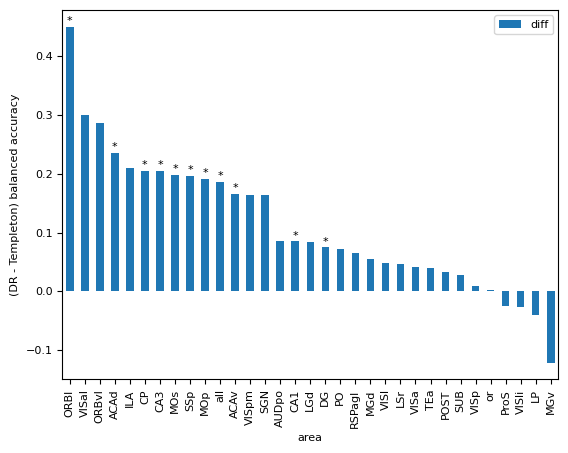

In [237]:
fig,ax=plt.subplots(1,1)

sel_areas_df=area_dr_templ_diff_df.query('dr_n >= 2 and templ_n >= 2').sort_values(by='diff',ascending=False).reset_index()

sel_areas_df.plot.bar(x='area',y='diff',ax=ax)

for aa,sel_area in sel_areas_df.iterrows():
    if sel_area['p']<0.05:
        ax.text(x=aa,y=sel_area['diff']+0.01,s='*',horizontalalignment='center',verticalalignment='center')

ax.set_ylabel('(DR - Templeton) balanced accuracy')

In [233]:
sel_areas_df

,area,diff,p,dr_n,templ_n
22,ORBl,0.450408,0.025347,5,3
11,VISal,0.299639,0.083265,2,3
19,ORBvl,0.286689,0.121335,2,2
5,ACAd,0.235764,0.005007,13,6
14,ILA,0.210462,0.083265,2,3
24,CP,0.205217,0.000287,40,12
46,CA3,0.204621,0.026224,14,2
6,MOs,0.197572,0.000002,46,27
21,SSp,0.196305,0.021536,30,4
15,MOp,0.191012,0.001374,30,9


<Axes: xlabel='area'>

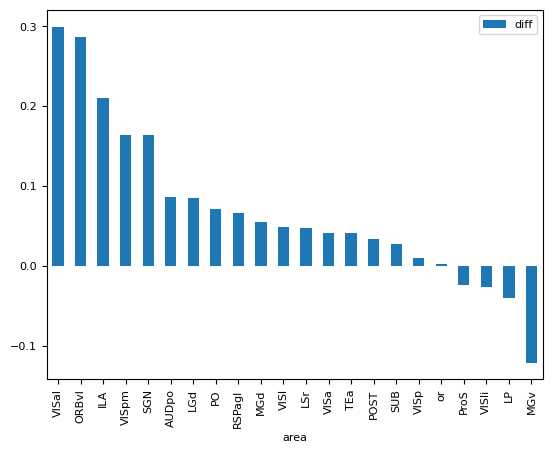

In [224]:
fig,ax=plt.subplots(1,1)
area_dr_templ_diff_df.query('dr_n >= 2 and templ_n >= 2 and p>=0.05').sort_values(by='diff',ascending=False).plot.bar(x='area',y='diff',ax=ax)

In [238]:
block_numbers=np.arange(0,6)
train_blocks=[]
test_blocks=[]

for bb in block_numbers[:-2]:
    train_blocks.append([bb,bb+1,bb+2])
    if bb==0:
        test_blocks.append([bb+3])
    elif bb==block_numbers[-3]:
        test_blocks.append([bb-1])
    else:
        test_blocks.append([bb-1,bb+3])

In [239]:
train_blocks

[[0, 1, 2], [1, 2, 3], [2, 3, 4], [3, 4, 5]]

In [240]:
test_blocks

[[3], [0, 4], [1, 5], [2]]